In [1]:
from models.cnp import CNP
from models.wta_cnp import WTA_CNP

from data.data_generators import *
import torch


def get_available_gpu_with_most_memory():
    gpu_memory = []
    for i in range(torch.cuda.device_count()):
        torch.cuda.set_device(i)  # Switch to the GPU to accurately measure memory
        gpu_memory.append((i, torch.cuda.memory_stats()['reserved_bytes.all.current'] / (1024 ** 2)))
    
    gpu_memory.sort(key=lambda x: x[1], reverse=True)
    
    return gpu_memory[0][0]

if torch.cuda.is_available():
    available_gpu = get_available_gpu_with_most_memory()
    if available_gpu == 0:
        device_wta = torch.device("cuda:0")
        device_cnp = torch.device("cuda:0")
    else:
        device_wta = torch.device(f"cuda:{available_gpu}")
        device_cnp = torch.device(f"cuda:{available_gpu}")
else:
    device_wta = torch.device("cpu")
    device_cnp = torch.device("cpu")

print("Device WTA:", device_wta, "Device CNP:", device_cnp)

Device WTA: cuda:0 Device CNP: cuda:0


In [2]:
batch_size = 4
n_max_obs, n_max_tar = 10, 10

t_steps = 200
num_demos = 8
num_classes = 2
num_indiv = num_demos//num_classes  # number of demos per class
noise_clip = 0.0
dx, dy = 1, 1

num_val = 4
num_val_indiv = num_val//num_classes

colors = ['tomato', 'aqua', 'limegreen', 'gold']

num_inc = 0
num_exc = 0

fixed_obs_ratio = 0.00000

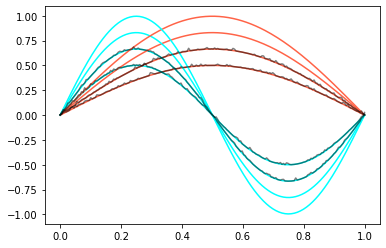

In [3]:
x = torch.linspace(0, 1, 200).repeat(num_demos, 1).unsqueeze(-1)
y = torch.zeros(num_demos, t_steps, dy)

vx = torch.linspace(0, 1, 200).repeat(num_val, 1).unsqueeze(-1)
vy = torch.zeros(num_val, t_steps, dy)

y[0] = torch.unsqueeze(generate_sin(x[0]), 0) / 2.0
y[1] = torch.unsqueeze(generate_sin(x[0] * 2), 0) / 2.0

coef = 1
for i in range(num_indiv-1):
    coef += 0.33
    start_ind = (i+1) * num_classes
    y[start_ind] = y[0].clone() * coef
    y[start_ind+1] = y[1].clone() * coef
    
for i in range(num_val):
    noise = torch.unsqueeze(torch.clamp(torch.randn(x[0].shape)*1e-4**0.5, min=0) - noise_clip, 0)
    vy[i] = y[i].clone() + noise

from matplotlib import pyplot as plt

for i in range(num_indiv):
    plt.plot(x[i*num_classes, :, 0].cpu(), y[i*num_classes, :, 0].cpu(), colors[0%num_classes])
    plt.plot(x[i*num_classes+1, :, 0].cpu(), y[i*num_classes+1, :, 0].cpu(), colors[1%num_classes])

for i in range(num_val):
    plt.plot(vx[i, :, 0].cpu(), vy[i, :, 0].cpu(), 'k', alpha=0.5)


x0, y0 = x.to(device_wta), y.to(device_wta)
x1, y1 = x.to(device_cnp), y.to(device_cnp)

In [4]:
def get_batch(x, y, traj_ids, device=device_wta):
    global num_inc, num_exc


    # if the following holds, we condition on 0, -1 or [0, -1] to estimate the rest
    # if not, we condition on random-numbered random points
    if torch.rand(1) < fixed_obs_ratio:
        num_inc += 1
        
        if torch.rand(1) < 0.33:
            n_o = 1  # [0]
            n_t = t_steps - 1
            o_ids = torch.tensor([0])
            t_ids = torch.randperm(t_steps-1)+1  # excluding [0]
        elif torch.rand(1) < 0.66:
            n_o = 1  # [-1]
            n_t = t_steps - 1
            o_ids = torch.tensor([-1])
            t_ids = torch.randperm(t_steps-1)  # excluding [-1]
        else:
            n_o = 2  # [0, -1]
            n_t = t_steps - 2
            o_ids = torch.tensor([0, -1])
            t_ids = torch.randperm(t_steps-2)+1  # excluding [0] and [-1]

        fixed = True
    
    else:
        num_exc += 1
        n_o = torch.randint(1, n_max_obs, (1,)).item()
        n_t = torch.randint(1, n_max_tar, (1,)).item()
        fixed = False

    tar = torch.zeros(batch_size, n_t, dx, device=device)
    tar_val = torch.zeros(batch_size, n_t, dy, device=device)
    obs = torch.zeros(batch_size, n_o, dx+dy, device=device)
    
    for i in range(len(traj_ids)):
        if not fixed:
            random_query_ids = torch.randperm(t_steps) 
            
            o_ids = random_query_ids[:n_o]
            t_ids = random_query_ids[n_o:n_o+n_t]

        obs[i, :, :] = torch.cat((x[traj_ids[i], o_ids], y[traj_ids[i], o_ids]), dim=-1)
        tar[i, :, :] = x[traj_ids[i], t_ids]
        tar_val[i, :, :] = y[traj_ids[i], t_ids]

    return obs, tar, tar_val

def get_validation_batch(vx, vy, traj_ids, device=device_wta):
    num_obs = torch.randint(1, n_max_obs, (1,)).item()

    obs = torch.zeros(batch_size, num_obs, dx+dy, device=device)
    tar = torch.zeros(batch_size, t_steps, dx, device=device)
    tar_val = torch.zeros(batch_size, t_steps, dy, device=device)

    for i in range(len(traj_ids)):
        random_query_ids = torch.randperm(t_steps)
        o_ids = random_query_ids[:num_obs]

        obs[i, :, :] = torch.cat((vx[traj_ids[i], o_ids], vy[traj_ids[i], o_ids]), dim=-1)
        tar[i, :, :] = vx[traj_ids[i]]
        tar_val[i, :, :] = vy[traj_ids[i]]

    return obs, tar, tar_val

In [5]:
model_wta = WTA_CNP(1, 1, n_max_obs, n_max_tar, [128, 128, 128], num_decoders=2, decoder_hidden_dims=[128, 128, 128], batch_size=batch_size).to(device_wta)
optimizer_wta = torch.optim.Adam(lr=1e-4, params=model_wta.parameters())

model_cnp = CNP(input_dim=1, hidden_dim=158, output_dim=1, n_max_obs=n_max_obs, n_max_tar=n_max_tar, num_layers=3, batch_size=batch_size).to(device_cnp)
optimizer_cnp = torch.optim.Adam(lr=1e-4, params=model_cnp.parameters())

# print("WTA Model:", model_wta)

In [6]:
def get_parameter_count(model):
    total_num = 0
    for param in model.parameters():
        total_num += param.shape.numel()
    return total_num

print("WTA-CNP:", get_parameter_count(model_wta))
print("CNP:", get_parameter_count(model_cnp))

WTA-CNP: 100486
CNP: 101438


In [7]:
from matplotlib.lines import Line2D


def draw_val_plot(root_folder, epoch):
    plt_y_lim = torch.max(vy) + 0.1

    obs = torch.zeros((batch_size, 1, 1, 2)).to(device_wta)
    for i in range(batch_size):
        obs[i] = torch.Tensor([x[i, 80, 0], y[i, 80, 0]]).unsqueeze(0).unsqueeze(0).to(device_wta)

    tar = torch.linspace(0, 1, 200).unsqueeze(0).unsqueeze(-1).to(device_wta)

    with torch.no_grad():
        for i in range(batch_size):
            pred_cnp, _ = model_cnp(obs[i], tar)
            pred_wta, gate = model_wta(obs[i], tar)
            print(pred_wta.shape)

            plt.ylim((-plt_y_lim, plt_y_lim))
            plt.scatter(obs[i,:,:,0].cpu(), obs[i,:,:,1].cpu(), c='k')
            for j in range(model_wta.num_decoders):
                plt.plot(torch.linspace(0, 1, 200), pred_wta[j,i,:,0].cpu(), colors[j], alpha=max(0.2, gate[0, 0, j].item()))  # wta pred
            plt.plot(torch.linspace(0, 1, 200), pred_cnp[:, :, :model_cnp.output_dim].squeeze(0).cpu(), 'b')  # cnp pred
            handles = []
            for j in range(batch_size):
                plt.plot(torch.linspace(0, 1, 200), vy[j].squeeze(-1).cpu(), 'k', alpha=0.05 if j!=i else 0.35)  # data
                handles.append(Line2D([0], [0], label=f'gate{j}: {gate[0, 0, j].item():.4f}', color=colors[j]))

            plt.legend(handles=handles, loc='upper right')

            plt.savefig(f'{root_folder}img/{i}_{epoch}.png')
            plt.close()

In [8]:
import time
import os

timestamp = int(time.time())
root_folder = f'outputs/sines/{str(timestamp)}/'

if not os.path.exists(root_folder):
    os.makedirs(root_folder)

if not os.path.exists(f'{root_folder}saved_models/'):
    os.makedirs(f'{root_folder}saved_models/')

if not os.path.exists(f'{root_folder}img/'):
    os.makedirs(f'{root_folder}img/')

torch.save(y, f'{root_folder}y.pt')


epochs = 750_000
epoch_iter = num_demos//batch_size  # number of batches per epoch (e.g. 100//32 = 3)
v_epoch_iter = num_val//batch_size  # number of batches per validation (e.g. 100//32 = 3)
avg_loss_wta, avg_loss_cnp = 0, 0

val_per_epoch = 1000
min_val_loss_wta, min_val_loss_cnp = 1000000, 1000000

mse_loss = torch.nn.MSELoss()

training_loss_wta, validation_error_wta = [], []
training_loss_cnp, validation_error_cnp = [], []

wta_tr_loss_path = f'{root_folder}wta_training_loss.pt'
wta_val_err_path = f'{root_folder}wta_validation_error.pt'
cnp_tr_loss_path = f'{root_folder}cnp_training_loss.pt'
cnp_val_err_path = f'{root_folder}cnp_validation_error.pt'

for epoch in range(epochs):
    epoch_loss_wta, epoch_loss_cnp = 0, 0

    traj_ids = torch.randperm(x.shape[0])[:batch_size*epoch_iter].chunk(epoch_iter)  # [:batch_size*epoch_iter] because nof_trajectories may be indivisible by batch_size

    for i in range(epoch_iter):
        optimizer_wta.zero_grad()
        optimizer_cnp.zero_grad()

        obs_wta, tar_x_wta, tar_y_wta = get_batch(x, y, traj_ids[i], device_wta)
        obs_cnp, tar_x_cnp, tar_y_cnp = obs_wta.clone(), tar_x_wta.clone(), tar_y_wta.clone()

        pred_wta, gate_wta = model_wta(obs_wta, tar_x_wta)
        pred_cnp, encoded_rep_cnp = model_cnp(obs_cnp, tar_x_cnp)

        loss_wta, wta_nll = model_wta.loss(pred_wta, gate_wta, tar_y_wta)

        loss_wta.backward()
        optimizer_wta.step()

        loss_cnp = model_cnp.loss(pred_cnp, tar_y_cnp)
        loss_cnp.backward()
        optimizer_cnp.step()

        epoch_loss_wta += wta_nll.item()
        epoch_loss_cnp += loss_cnp.item()

    training_loss_wta.append(epoch_loss_wta)
    training_loss_cnp.append(epoch_loss_cnp)

    if epoch % val_per_epoch == 0:
        with torch.no_grad():
            v_traj_ids = torch.randperm(vx.shape[0])[:batch_size*v_epoch_iter].chunk(v_epoch_iter)
            val_loss_wta, val_loss_cnp = 0, 0

            for j in range(v_epoch_iter):
                o_wta, t_wta, tr_wta = get_validation_batch(vx, vy, v_traj_ids[j], device=device_wta)
                o_cnp, t_cnp, tr_cnp = o_wta.clone(), t_wta.clone(), tr_wta.clone()

                p_wta, g_wta = model_wta(o_wta, t_wta)
                dec_id = torch.argmax(g_wta.squeeze(1), dim=-1)
                vp_means = p_wta[dec_id, torch.arange(batch_size), :, :dy]
                val_loss_wta += mse_loss(vp_means, tr_wta).item()

                pred_cnp, encoded_rep = model_cnp(o_cnp, t_cnp)
                val_loss_cnp += mse_loss(pred_cnp[:, :, :model_cnp.output_dim], tr_cnp)


            validation_error_wta.append(val_loss_wta)
            if val_loss_wta < min_val_loss_wta:
                min_val_loss_wta = val_loss_wta
                print(f'(WTA)New best: {min_val_loss_wta}')
                torch.save(model_wta.state_dict(), f'{root_folder}saved_models/wta_on_synth.pt')

            validation_error_cnp.append(val_loss_cnp.item())
            if val_loss_cnp < min_val_loss_cnp:
                min_val_loss_cnp = val_loss_cnp
                print(f'(CNP)New best: {min_val_loss_cnp}')
                torch.save(model_cnp.state_dict(), f'{root_folder}saved_models/cnp_on_synth.pt')
  
#         if epoch % (val_per_epoch*10) == 0:
#             draw_val_plot(root_folder, epoch)


    avg_loss_wta += epoch_loss_wta
    avg_loss_cnp += epoch_loss_cnp

    if epoch % 100 == 0:
        print("Epoch: {}, WTA-Loss: {}, CNP-Loss: {}".format(epoch, avg_loss_wta/100, avg_loss_cnp/100))
        avg_loss_wta, avg_loss_cnp = 0, 0

    if epoch % 100000:
        torch.save(torch.Tensor(training_loss_wta), wta_tr_loss_path)
        torch.save(torch.Tensor(validation_error_wta), wta_val_err_path)
        torch.save(torch.Tensor(training_loss_cnp), cnp_tr_loss_path)
        torch.save(torch.Tensor(validation_error_cnp), cnp_val_err_path)

(WTA)New best: 0.18570725619792938
(CNP)New best: 0.18821579217910767
Epoch: 0, WTA-Loss: 0.015352849364280701, CNP-Loss: 0.014871024489402772
Epoch: 100, WTA-Loss: 1.3540326449275017, CNP-Loss: 1.2657218144088984
Epoch: 200, WTA-Loss: 1.0855555881559849, CNP-Loss: 1.0206887247040868
Epoch: 300, WTA-Loss: 1.0030910073965789, CNP-Loss: 0.9454124453291297
Epoch: 400, WTA-Loss: 0.8851506931893528, CNP-Loss: 0.845185489114374
Epoch: 500, WTA-Loss: 0.7178856640681625, CNP-Loss: 0.6884938311949372
Epoch: 600, WTA-Loss: 0.6980373753793537, CNP-Loss: 0.6335376179148443
Epoch: 700, WTA-Loss: 0.5240993469953537, CNP-Loss: 0.4759944835561328
Epoch: 800, WTA-Loss: 0.39604140067473054, CNP-Loss: 0.3637618846166879
Epoch: 900, WTA-Loss: 0.3726112544722855, CNP-Loss: 0.31021177388262006
(WTA)New best: 0.04491261765360832
(CNP)New best: 0.03876345977187157
Epoch: 1000, WTA-Loss: 0.2787142117135227, CNP-Loss: 0.2143746252049459
Epoch: 1100, WTA-Loss: 0.18444835752248764, CNP-Loss: 0.10560237747442443
E

Epoch: 10500, WTA-Loss: -3.0700247714668514, CNP-Loss: -2.5888435456342993
Epoch: 10600, WTA-Loss: -2.921550904586911, CNP-Loss: -2.608986469209194
Epoch: 10700, WTA-Loss: -3.106800274848938, CNP-Loss: -2.7092057548463346
Epoch: 10800, WTA-Loss: -3.229517771154642, CNP-Loss: -2.733696324713528
Epoch: 10900, WTA-Loss: -2.602208793461323, CNP-Loss: -2.5676227709278465
(WTA)New best: 0.001172226038761437
(CNP)New best: 0.018479788675904274
Epoch: 11000, WTA-Loss: -2.9511033219099043, CNP-Loss: -2.627180318310857
Epoch: 11100, WTA-Loss: -3.3263691261410715, CNP-Loss: -2.764317986998358
Epoch: 11200, WTA-Loss: -2.8371572041511537, CNP-Loss: -2.453786173760891
Epoch: 11300, WTA-Loss: -1.782607325464487, CNP-Loss: -2.5973573701828716
Epoch: 11400, WTA-Loss: -2.6417755420506, CNP-Loss: -2.4306590972095727
Epoch: 11500, WTA-Loss: -3.259314927458763, CNP-Loss: -2.933957258351147
Epoch: 11600, WTA-Loss: -3.260947691425681, CNP-Loss: -2.8497144374251366
Epoch: 11700, WTA-Loss: -3.0822500567138196,

Epoch: 21200, WTA-Loss: -4.336048690751195, CNP-Loss: -4.075751551091671
Epoch: 21300, WTA-Loss: -4.310598778128624, CNP-Loss: -3.7355712081491945
Epoch: 21400, WTA-Loss: -4.090734961032868, CNP-Loss: -4.021353768249973
Epoch: 21500, WTA-Loss: -4.031053415313363, CNP-Loss: -3.995635120184161
Epoch: 21600, WTA-Loss: -4.39539152443409, CNP-Loss: -4.1706772133708
Epoch: 21700, WTA-Loss: -4.395798788666725, CNP-Loss: -3.9812018044292925
Epoch: 21800, WTA-Loss: -4.407109182178974, CNP-Loss: -4.1827866241894665
Epoch: 21900, WTA-Loss: -4.075963862687349, CNP-Loss: -3.983192922472954
(CNP)New best: 0.0020543697755783796
Epoch: 22000, WTA-Loss: -3.9392837730050085, CNP-Loss: -4.064805548377335
Epoch: 22100, WTA-Loss: -3.9263753417134284, CNP-Loss: -4.206459264904261
Epoch: 22200, WTA-Loss: -4.4331999558210375, CNP-Loss: -4.180613960251212
Epoch: 22300, WTA-Loss: -4.107870751023293, CNP-Loss: -4.155414486080408
Epoch: 22400, WTA-Loss: -4.20168021813035, CNP-Loss: -4.037143978178501
Epoch: 22500

Epoch: 32100, WTA-Loss: -5.064568297863007, CNP-Loss: -4.938504718393087
Epoch: 32200, WTA-Loss: -4.983318489789963, CNP-Loss: -4.850980758666992
Epoch: 32300, WTA-Loss: -4.679255447089672, CNP-Loss: -4.696557854562998
Epoch: 32400, WTA-Loss: -4.1910598555207255, CNP-Loss: -4.709387785494328
Epoch: 32500, WTA-Loss: -4.835539156794548, CNP-Loss: -5.038110588248819
Epoch: 32600, WTA-Loss: -5.174556396603585, CNP-Loss: -4.887007894515992
Epoch: 32700, WTA-Loss: -4.881292465254664, CNP-Loss: -4.573185883164406
Epoch: 32800, WTA-Loss: -4.843447578251362, CNP-Loss: -4.911341888159513
Epoch: 32900, WTA-Loss: -4.862572794854641, CNP-Loss: -4.7721941168606286
Epoch: 33000, WTA-Loss: -4.927108964622021, CNP-Loss: -5.0002528232336045
Epoch: 33100, WTA-Loss: -4.840171785727144, CNP-Loss: -4.7277650603652
Epoch: 33200, WTA-Loss: -4.986410443782806, CNP-Loss: -4.977678901851177
Epoch: 33300, WTA-Loss: -4.904718735814095, CNP-Loss: -4.707626545280218
Epoch: 33400, WTA-Loss: -5.049203014671803, CNP-Lo

Epoch: 43300, WTA-Loss: -5.422937440574169, CNP-Loss: -5.201380029022694
Epoch: 43400, WTA-Loss: -5.667770871818066, CNP-Loss: -5.108140570223331
Epoch: 43500, WTA-Loss: -5.7208373785018924, CNP-Loss: -5.413082290887832
Epoch: 43600, WTA-Loss: -5.526032163351775, CNP-Loss: -5.382826839461923
Epoch: 43700, WTA-Loss: -5.647166681885719, CNP-Loss: -5.374177585840226
Epoch: 43800, WTA-Loss: -5.774988815188408, CNP-Loss: -5.244905957691372
Epoch: 43900, WTA-Loss: -5.5209094112366435, CNP-Loss: -5.355954232811928
Epoch: 44000, WTA-Loss: -4.799440950006247, CNP-Loss: -5.091919230073691
Epoch: 44100, WTA-Loss: -5.565331651568413, CNP-Loss: -5.39847892165184
Epoch: 44200, WTA-Loss: -5.430745257139206, CNP-Loss: -5.202019642144442
Epoch: 44300, WTA-Loss: -5.574776086807251, CNP-Loss: -5.0375590109825135
Epoch: 44400, WTA-Loss: -5.427659858465194, CNP-Loss: -5.248088671080768
Epoch: 44500, WTA-Loss: -5.641523082256317, CNP-Loss: -5.321050930321217
Epoch: 44600, WTA-Loss: -5.1685765421390535, CNP-

Epoch: 54500, WTA-Loss: -5.804715290442109, CNP-Loss: -5.504057183973491
Epoch: 54600, WTA-Loss: -5.6082190695405005, CNP-Loss: -5.555500844419003
Epoch: 54700, WTA-Loss: -4.64917242705822, CNP-Loss: -5.516736949682236
Epoch: 54800, WTA-Loss: -5.712162192463875, CNP-Loss: -5.513581168055534
Epoch: 54900, WTA-Loss: -5.517666290253401, CNP-Loss: -5.520785605683923
Epoch: 55000, WTA-Loss: -5.661472571194172, CNP-Loss: -5.662386325001717
Epoch: 55100, WTA-Loss: -5.9399114018678665, CNP-Loss: -5.324771563671529
Epoch: 55200, WTA-Loss: -5.795742191076279, CNP-Loss: -5.694697395563126
Epoch: 55300, WTA-Loss: -5.8712437009811405, CNP-Loss: -5.548459576666355
Epoch: 55400, WTA-Loss: -5.909471803307533, CNP-Loss: -5.765601068735123
Epoch: 55500, WTA-Loss: -5.648403651714325, CNP-Loss: -5.546271513700486
Epoch: 55600, WTA-Loss: -5.9680259883403775, CNP-Loss: -5.5518503773212435
Epoch: 55700, WTA-Loss: -5.340709312707186, CNP-Loss: -5.755307602584362
Epoch: 55800, WTA-Loss: -5.783572453558445, CNP

Epoch: 65700, WTA-Loss: -5.8576865202188495, CNP-Loss: -5.915625522136688
Epoch: 65800, WTA-Loss: -5.582353594079613, CNP-Loss: -5.806750291064382
Epoch: 65900, WTA-Loss: -5.195223008096218, CNP-Loss: -5.626314755380154
Epoch: 66000, WTA-Loss: -5.397557933926582, CNP-Loss: -5.848573911935091
Epoch: 66100, WTA-Loss: -4.718342441916466, CNP-Loss: -5.728311678022147
Epoch: 66200, WTA-Loss: -5.519742931723595, CNP-Loss: -5.620003120601178
Epoch: 66300, WTA-Loss: -6.044517579078675, CNP-Loss: -5.452626709342002
Epoch: 66400, WTA-Loss: -6.240927889943123, CNP-Loss: -5.788780466914177
Epoch: 66500, WTA-Loss: -5.974308389723301, CNP-Loss: -5.710320014804601
Epoch: 66600, WTA-Loss: -6.159443938732148, CNP-Loss: -5.784854654669761
Epoch: 66700, WTA-Loss: -5.948501841425895, CNP-Loss: -5.3335047671198845
Epoch: 66800, WTA-Loss: -6.071972658038139, CNP-Loss: -5.906414672136306
Epoch: 66900, WTA-Loss: -5.409648328721524, CNP-Loss: -5.368961825370788
Epoch: 67000, WTA-Loss: -6.02934831738472, CNP-Lo

Epoch: 76900, WTA-Loss: -6.41232725918293, CNP-Loss: -5.912998232841492
Epoch: 77000, WTA-Loss: -5.897172097861767, CNP-Loss: -5.852791373580694
Epoch: 77100, WTA-Loss: -5.30961659297347, CNP-Loss: -6.039404165148735
Epoch: 77200, WTA-Loss: -6.192321527302266, CNP-Loss: -5.808973672240972
Epoch: 77300, WTA-Loss: -6.014967215657234, CNP-Loss: -5.840020380914211
Epoch: 77400, WTA-Loss: -5.87492884516716, CNP-Loss: -5.963515480160713
Epoch: 77500, WTA-Loss: -6.184174883961678, CNP-Loss: -6.163953281641007
Epoch: 77600, WTA-Loss: -6.086537427902222, CNP-Loss: -6.097259649038315
Epoch: 77700, WTA-Loss: -6.398353872895241, CNP-Loss: -5.929115786254406
Epoch: 77800, WTA-Loss: -6.239552658796311, CNP-Loss: -5.7291579592227935
Epoch: 77900, WTA-Loss: -6.471921311616898, CNP-Loss: -5.966848250627518
Epoch: 78000, WTA-Loss: -6.37248899102211, CNP-Loss: -5.846515352725983
Epoch: 78100, WTA-Loss: -6.569593842029572, CNP-Loss: -6.2174707281589505
Epoch: 78200, WTA-Loss: -6.372383705079556, CNP-Loss:

Epoch: 88100, WTA-Loss: -6.290664736032486, CNP-Loss: -5.967814799547195
Epoch: 88200, WTA-Loss: -6.432307800352573, CNP-Loss: -5.407694169282913
Epoch: 88300, WTA-Loss: -6.147852654457092, CNP-Loss: -6.1503194093704225
Epoch: 88400, WTA-Loss: -6.374911777973175, CNP-Loss: -5.911656896471977
Epoch: 88500, WTA-Loss: -6.084515763521194, CNP-Loss: -5.951127243638038
Epoch: 88600, WTA-Loss: -5.890723722577095, CNP-Loss: -5.836244736909866
Epoch: 88700, WTA-Loss: -6.724062210321426, CNP-Loss: -5.929474136233329
Epoch: 88800, WTA-Loss: -6.513128117322922, CNP-Loss: -6.153187608122826
Epoch: 88900, WTA-Loss: -6.153649690896272, CNP-Loss: -6.301874711513519
Epoch: 89000, WTA-Loss: -6.5753568249940875, CNP-Loss: -6.199938970208168
Epoch: 89100, WTA-Loss: -6.393725416064262, CNP-Loss: -5.944849895238876
Epoch: 89200, WTA-Loss: -6.544087501764298, CNP-Loss: -6.040784934610128
Epoch: 89300, WTA-Loss: -5.760139410495758, CNP-Loss: -5.862106110006571
Epoch: 89400, WTA-Loss: -4.866790395379066, CNP-L

Epoch: 99300, WTA-Loss: -6.337398963868618, CNP-Loss: -6.281718183755874
Epoch: 99400, WTA-Loss: -6.201555864214897, CNP-Loss: -6.26400019466877
Epoch: 99500, WTA-Loss: -6.429554957151413, CNP-Loss: -5.975442504882812
Epoch: 99600, WTA-Loss: -6.083240564763546, CNP-Loss: -5.92929384291172
Epoch: 99700, WTA-Loss: -6.319026817083358, CNP-Loss: -6.1979928117990495
Epoch: 99800, WTA-Loss: -6.027254789471626, CNP-Loss: -6.137830674499273
Epoch: 99900, WTA-Loss: -6.696787344813347, CNP-Loss: -6.414931597709656
Epoch: 100000, WTA-Loss: -6.040659192800522, CNP-Loss: -6.095567943453789
Epoch: 100100, WTA-Loss: -6.504827155470848, CNP-Loss: -6.0368641075491905
Epoch: 100200, WTA-Loss: -6.581003051698207, CNP-Loss: -6.277331400513649
Epoch: 100300, WTA-Loss: -6.308657515645027, CNP-Loss: -5.944994305074215
Epoch: 100400, WTA-Loss: -6.199125080108643, CNP-Loss: -6.015290926098824
Epoch: 100500, WTA-Loss: -6.656359325051308, CNP-Loss: -6.122216663956642
Epoch: 100600, WTA-Loss: -6.556955833435058, 

Epoch: 110200, WTA-Loss: -6.470565132498741, CNP-Loss: -6.314419943094253
Epoch: 110300, WTA-Loss: -6.672654680013657, CNP-Loss: -6.021019540429116
Epoch: 110400, WTA-Loss: -5.840653922557831, CNP-Loss: -6.472925527095795
Epoch: 110500, WTA-Loss: -5.932132784128189, CNP-Loss: -5.881985377967357
Epoch: 110600, WTA-Loss: -2.7563280948996542, CNP-Loss: -6.412684788107872
Epoch: 110700, WTA-Loss: -4.390230014324188, CNP-Loss: -6.219976222515106
Epoch: 110800, WTA-Loss: -5.052637175321579, CNP-Loss: -6.049582995176316
Epoch: 110900, WTA-Loss: -3.283113934993744, CNP-Loss: -6.401325035095215
Epoch: 111000, WTA-Loss: -4.57944571018219, CNP-Loss: -6.294075428247452
Epoch: 111100, WTA-Loss: -5.455318671613932, CNP-Loss: -6.184615529291332
Epoch: 111200, WTA-Loss: -5.7451512348651885, CNP-Loss: -6.290916895195842
Epoch: 111300, WTA-Loss: -5.681376501023769, CNP-Loss: -6.24790117830038
Epoch: 111400, WTA-Loss: -5.9504111880064015, CNP-Loss: -6.471857933700084
Epoch: 111500, WTA-Loss: -6.053827617

Epoch: 121300, WTA-Loss: -6.777228670120239, CNP-Loss: -6.251180027723312
Epoch: 121400, WTA-Loss: 6.976640496701002, CNP-Loss: -6.501102033555508
Epoch: 121500, WTA-Loss: -4.768273545950652, CNP-Loss: -6.318350393176079
Epoch: 121600, WTA-Loss: -4.235241641551256, CNP-Loss: -6.3147452276945115
Epoch: 121700, WTA-Loss: -5.357983975112438, CNP-Loss: -6.404024013876915
Epoch: 121800, WTA-Loss: -5.656008382439613, CNP-Loss: -6.346780613362789
Epoch: 121900, WTA-Loss: -5.689200669527054, CNP-Loss: -6.589044131040573
(CNP)New best: 7.677345274714753e-05
Epoch: 122000, WTA-Loss: -6.228692668378353, CNP-Loss: -5.885721153020858
Epoch: 122100, WTA-Loss: -6.335657639503479, CNP-Loss: -6.5188272142410275
Epoch: 122200, WTA-Loss: -5.542537990361452, CNP-Loss: -6.367107675224543
Epoch: 122300, WTA-Loss: -6.524701442718506, CNP-Loss: -6.344363103508949
Epoch: 122400, WTA-Loss: -6.643038812875748, CNP-Loss: -6.18281690120697
Epoch: 122500, WTA-Loss: -4.648111266493797, CNP-Loss: -5.989536098241806
E

Epoch: 132300, WTA-Loss: -6.850626283586025, CNP-Loss: -6.504474404454231
Epoch: 132400, WTA-Loss: -6.368863421082497, CNP-Loss: -6.454838104248047
Epoch: 132500, WTA-Loss: -6.6716462424397465, CNP-Loss: -6.542476640343666
Epoch: 132600, WTA-Loss: -6.85683308750391, CNP-Loss: -6.31786706417799
Epoch: 132700, WTA-Loss: -6.948601828217506, CNP-Loss: -6.630306877493858
Epoch: 132800, WTA-Loss: -6.594987690746784, CNP-Loss: -6.553366949856281
Epoch: 132900, WTA-Loss: -6.786952533721924, CNP-Loss: -6.26103440284729
Epoch: 133000, WTA-Loss: -6.8463376095891, CNP-Loss: -6.3529509165883065
Epoch: 133100, WTA-Loss: -7.256664263010025, CNP-Loss: -6.801133338212967
Epoch: 133200, WTA-Loss: -6.521072072386741, CNP-Loss: -6.483897288143635
Epoch: 133300, WTA-Loss: -6.870861084163189, CNP-Loss: -6.311813569068908
Epoch: 133400, WTA-Loss: -6.979884110689163, CNP-Loss: -6.796976972818374
Epoch: 133500, WTA-Loss: -6.404611861109734, CNP-Loss: -5.871132071018219
Epoch: 133600, WTA-Loss: -6.7630216795206

Epoch: 143400, WTA-Loss: -6.775245419740677, CNP-Loss: -6.493041178435087
Epoch: 143500, WTA-Loss: -6.835208995938301, CNP-Loss: -6.5128275039792065
Epoch: 143600, WTA-Loss: -6.644082284867763, CNP-Loss: -6.79669668674469
Epoch: 143700, WTA-Loss: -6.722324798107147, CNP-Loss: -6.667477892637253
Epoch: 143800, WTA-Loss: -6.596407326161861, CNP-Loss: -6.680160605311394
Epoch: 143900, WTA-Loss: -6.735800957679748, CNP-Loss: -6.519561901688576
Epoch: 144000, WTA-Loss: -6.841031984686851, CNP-Loss: -6.648259595632553
Epoch: 144100, WTA-Loss: -6.5707490301132205, CNP-Loss: -6.549111206531524
Epoch: 144200, WTA-Loss: -6.97584930896759, CNP-Loss: -6.604178458452225
Epoch: 144300, WTA-Loss: -6.291179861426354, CNP-Loss: -6.667496472597122
Epoch: 144400, WTA-Loss: -6.961555853486061, CNP-Loss: -6.630658205747604
Epoch: 144500, WTA-Loss: -3.727412642389536, CNP-Loss: -6.595581355690956
Epoch: 144600, WTA-Loss: -6.10791356086731, CNP-Loss: -6.823800460398197
Epoch: 144700, WTA-Loss: -6.59593677341

Epoch: 154500, WTA-Loss: -6.342420876473188, CNP-Loss: -6.450835573077202
Epoch: 154600, WTA-Loss: -6.696120907068252, CNP-Loss: -6.7658948385715485
Epoch: 154700, WTA-Loss: -6.6973734813928605, CNP-Loss: -6.779696768671275
Epoch: 154800, WTA-Loss: -6.428219545483589, CNP-Loss: -6.798103442788124
Epoch: 154900, WTA-Loss: -6.713159961700439, CNP-Loss: -6.640617639422417
Epoch: 155000, WTA-Loss: -6.793293608427048, CNP-Loss: -6.714025475382805
Epoch: 155100, WTA-Loss: -6.34369081929326, CNP-Loss: -6.583016783297062
Epoch: 155200, WTA-Loss: -7.127777534723282, CNP-Loss: -6.532933754175901
Epoch: 155300, WTA-Loss: -6.594637136459351, CNP-Loss: -6.608620152175426
Epoch: 155400, WTA-Loss: -7.038832603543997, CNP-Loss: -5.83455518424511
Epoch: 155500, WTA-Loss: -5.298320492506027, CNP-Loss: -6.0843009272962805
Epoch: 155600, WTA-Loss: 0.9123124620318412, CNP-Loss: -6.690773826241493
Epoch: 155700, WTA-Loss: -4.441821408867836, CNP-Loss: -6.758919738531112
Epoch: 155800, WTA-Loss: -5.019899912

Epoch: 165600, WTA-Loss: -6.307811943292617, CNP-Loss: -6.18501703619957
Epoch: 165700, WTA-Loss: 4.242396911084652, CNP-Loss: -6.420825746655464
Epoch: 165800, WTA-Loss: -3.507834315299988, CNP-Loss: -6.372243753671646
Epoch: 165900, WTA-Loss: -4.291717378497124, CNP-Loss: -6.913036974072456
Epoch: 166000, WTA-Loss: -4.692184657454491, CNP-Loss: -6.750244444608688
Epoch: 166100, WTA-Loss: -4.885069994032383, CNP-Loss: -6.827319706082344
Epoch: 166200, WTA-Loss: -5.1845860424637795, CNP-Loss: -6.405921100378037
Epoch: 166300, WTA-Loss: -5.485784542560578, CNP-Loss: -6.947515054941177
Epoch: 166400, WTA-Loss: -5.486832844018936, CNP-Loss: -6.5032706129550935
Epoch: 166500, WTA-Loss: -5.557378049194813, CNP-Loss: -6.637116184234619
Epoch: 166600, WTA-Loss: -5.669316549003124, CNP-Loss: -6.737802014350891
Epoch: 166700, WTA-Loss: -6.188142204284668, CNP-Loss: -6.8728728121519085
Epoch: 166800, WTA-Loss: -6.093729367852211, CNP-Loss: -6.4582400923967365
Epoch: 166900, WTA-Loss: -6.30744328

Epoch: 176600, WTA-Loss: -7.017842970490456, CNP-Loss: -6.715997035503388
Epoch: 176700, WTA-Loss: -6.947840519919992, CNP-Loss: -7.208855578899383
Epoch: 176800, WTA-Loss: -7.037935156524181, CNP-Loss: -6.49484723597765
Epoch: 176900, WTA-Loss: -6.186046432256699, CNP-Loss: -6.664975053966045
Epoch: 177000, WTA-Loss: -6.882738702893257, CNP-Loss: -6.807344115972519
Epoch: 177100, WTA-Loss: -6.993994544148445, CNP-Loss: -6.919683439731598
Epoch: 177200, WTA-Loss: -6.705315008163452, CNP-Loss: -6.632859434485436
Epoch: 177300, WTA-Loss: -6.9966510888934135, CNP-Loss: -6.988488712310791
Epoch: 177400, WTA-Loss: -5.862935993075371, CNP-Loss: -6.519461100697518
Epoch: 177500, WTA-Loss: -6.961871769428253, CNP-Loss: -6.915287266969681
Epoch: 177600, WTA-Loss: -6.940841695666313, CNP-Loss: -6.348644166588783
Epoch: 177700, WTA-Loss: -6.741547132134437, CNP-Loss: -6.907128050327301
Epoch: 177800, WTA-Loss: -6.862089565992355, CNP-Loss: -6.841897902712226
Epoch: 177900, WTA-Loss: -6.6606908941

Epoch: 187700, WTA-Loss: -6.97193952858448, CNP-Loss: -6.983192012012005
Epoch: 187800, WTA-Loss: -6.959959428310395, CNP-Loss: -6.98983632683754
Epoch: 187900, WTA-Loss: -7.061986318826675, CNP-Loss: -7.024938950538635
Epoch: 188000, WTA-Loss: -6.94744369149208, CNP-Loss: -6.715100918710232
Epoch: 188100, WTA-Loss: -6.64820198237896, CNP-Loss: -6.833090101480484
Epoch: 188200, WTA-Loss: -7.063456774950027, CNP-Loss: -7.046269605755806
Epoch: 188300, WTA-Loss: -7.0497803723812105, CNP-Loss: -7.066571704149246
Epoch: 188400, WTA-Loss: -6.909279623627663, CNP-Loss: -6.684147834777832
Epoch: 188500, WTA-Loss: -7.403440409898758, CNP-Loss: -7.112616773247719
Epoch: 188600, WTA-Loss: -7.346472771167755, CNP-Loss: -6.97748864531517
Epoch: 188700, WTA-Loss: -7.013447921872139, CNP-Loss: -7.026058443784714
Epoch: 188800, WTA-Loss: -7.129249951839447, CNP-Loss: -6.849834693670273
Epoch: 188900, WTA-Loss: -6.982101522684097, CNP-Loss: -6.972552763223648
Epoch: 189000, WTA-Loss: -7.09068733334541

Epoch: 198800, WTA-Loss: -6.692876455485821, CNP-Loss: -6.794528283774853
Epoch: 198900, WTA-Loss: -6.699491548538208, CNP-Loss: -6.803924617171288
Epoch: 199000, WTA-Loss: -7.011398741006851, CNP-Loss: -7.067006906270981
Epoch: 199100, WTA-Loss: -6.88002656430006, CNP-Loss: -7.145455103218556
Epoch: 199200, WTA-Loss: -6.892641491889954, CNP-Loss: -6.8844996309280395
Epoch: 199300, WTA-Loss: -6.873337413668633, CNP-Loss: -6.968729480504989
Epoch: 199400, WTA-Loss: -7.331552522182465, CNP-Loss: -7.016462076604366
Epoch: 199500, WTA-Loss: -7.150418760180473, CNP-Loss: -6.957751432359219
Epoch: 199600, WTA-Loss: -6.866653019189835, CNP-Loss: -4.547126066684723
Epoch: 199700, WTA-Loss: -7.294619009494782, CNP-Loss: -6.590133109688759
Epoch: 199800, WTA-Loss: -6.327332982420922, CNP-Loss: -6.807410441637039
Epoch: 199900, WTA-Loss: -5.420761193037033, CNP-Loss: -7.007894535064697
Epoch: 200000, WTA-Loss: -6.796418429613113, CNP-Loss: -7.068426505327225
Epoch: 200100, WTA-Loss: -7.1836881089

Epoch: 209900, WTA-Loss: -7.651819686889649, CNP-Loss: -7.160194128751755
Epoch: 210000, WTA-Loss: -7.215051293969155, CNP-Loss: -7.142268795371056
Epoch: 210100, WTA-Loss: -7.3302033162117, CNP-Loss: -7.212900151014328
Epoch: 210200, WTA-Loss: -7.2352313601970675, CNP-Loss: -7.254861174821854
Epoch: 210300, WTA-Loss: -6.757481018304825, CNP-Loss: -7.138405305743217
Epoch: 210400, WTA-Loss: -7.1254958510398865, CNP-Loss: -7.07697411775589
Epoch: 210500, WTA-Loss: -6.781012375354766, CNP-Loss: -6.985300650000572
Epoch: 210600, WTA-Loss: -6.963700268864631, CNP-Loss: -7.049293570518493
Epoch: 210700, WTA-Loss: -7.08260951500386, CNP-Loss: -6.998666804432869
Epoch: 210800, WTA-Loss: -7.204721887111663, CNP-Loss: -7.094303992539644
Epoch: 210900, WTA-Loss: -6.991308243870735, CNP-Loss: -7.26160795211792
Epoch: 211000, WTA-Loss: -7.132659831643105, CNP-Loss: -6.984550858736038
Epoch: 211100, WTA-Loss: -6.833611627221107, CNP-Loss: -7.286358737945557
Epoch: 211200, WTA-Loss: -6.7445082204043

Epoch: 221000, WTA-Loss: -6.75099333614111, CNP-Loss: -7.242351323962212
Epoch: 221100, WTA-Loss: -6.052593070864678, CNP-Loss: -7.126698294878006
Epoch: 221200, WTA-Loss: -7.442038861513137, CNP-Loss: -7.179996193647384
Epoch: 221300, WTA-Loss: -7.355984996110201, CNP-Loss: -7.375707567036152
Epoch: 221400, WTA-Loss: -7.619172942638397, CNP-Loss: -7.3229456293582915
Epoch: 221500, WTA-Loss: -7.254283847808838, CNP-Loss: -7.224039853811264
Epoch: 221600, WTA-Loss: -7.595796105861663, CNP-Loss: -7.126141393780708
Epoch: 221700, WTA-Loss: -6.5002770936489105, CNP-Loss: -7.05679495215416
Epoch: 221800, WTA-Loss: -7.187943249344825, CNP-Loss: -6.970675203204155
Epoch: 221900, WTA-Loss: -5.226235846281051, CNP-Loss: -7.178927974700928
(CNP)New best: 5.3231204219628125e-05
Epoch: 222000, WTA-Loss: -6.876322196722031, CNP-Loss: -7.027718297243118
Epoch: 222100, WTA-Loss: -7.109019423723221, CNP-Loss: -5.751766214966774
Epoch: 222200, WTA-Loss: -7.371650818139314, CNP-Loss: -6.315130842328071


Epoch: 232100, WTA-Loss: -7.655520201772451, CNP-Loss: -7.08135826587677
Epoch: 232200, WTA-Loss: -7.250408393144608, CNP-Loss: -7.238555691242218
Epoch: 232300, WTA-Loss: -7.59376557469368, CNP-Loss: -7.287361477017402
Epoch: 232400, WTA-Loss: -7.427781190872192, CNP-Loss: -7.2479864120483395
Epoch: 232500, WTA-Loss: -4.775934050679207, CNP-Loss: -7.2564395081996915
Epoch: 232600, WTA-Loss: -6.77593598484993, CNP-Loss: -7.176426429748535
Epoch: 232700, WTA-Loss: -7.462330331802368, CNP-Loss: -7.013886892497539
Epoch: 232800, WTA-Loss: -7.15043983399868, CNP-Loss: -6.617090178728104
Epoch: 232900, WTA-Loss: -7.349710383415222, CNP-Loss: -7.1451914578676226
Epoch: 233000, WTA-Loss: -7.725084551721811, CNP-Loss: -7.1956257569789885
Epoch: 233100, WTA-Loss: -7.196631111502647, CNP-Loss: -7.138613413497805
Epoch: 233200, WTA-Loss: -7.550877907276154, CNP-Loss: -6.830393855571747
Epoch: 233300, WTA-Loss: -5.0021040090918545, CNP-Loss: -7.3347021889686586
Epoch: 233400, WTA-Loss: -6.85225443

Epoch: 243200, WTA-Loss: -6.810079147219658, CNP-Loss: -7.194483430385589
Epoch: 243300, WTA-Loss: -7.318154853582382, CNP-Loss: -7.016292608976364
Epoch: 243400, WTA-Loss: -6.939235224723816, CNP-Loss: -7.345672987699508
Epoch: 243500, WTA-Loss: -7.265859249830246, CNP-Loss: -7.124191296100617
Epoch: 243600, WTA-Loss: -7.510193695425987, CNP-Loss: -7.33494770526886
Epoch: 243700, WTA-Loss: -7.370038641691208, CNP-Loss: -7.297062944173813
Epoch: 243800, WTA-Loss: -7.478369292467833, CNP-Loss: -7.121339338421822
Epoch: 243900, WTA-Loss: -7.401354832053184, CNP-Loss: -7.119406596422196
Epoch: 244000, WTA-Loss: -7.528359783887863, CNP-Loss: -7.391858989000321
Epoch: 244100, WTA-Loss: -7.455550543665886, CNP-Loss: -7.280422742366791
Epoch: 244200, WTA-Loss: -6.822752587199211, CNP-Loss: -7.500344569087028
Epoch: 244300, WTA-Loss: -6.988084900379181, CNP-Loss: -7.056958809792995
Epoch: 244400, WTA-Loss: -7.057534404993057, CNP-Loss: -7.458235832452774
Epoch: 244500, WTA-Loss: -7.35608344674

Epoch: 254300, WTA-Loss: -7.198491123914718, CNP-Loss: -7.421752879619598
Epoch: 254400, WTA-Loss: -7.0168929553031925, CNP-Loss: -7.1077197384834285
Epoch: 254500, WTA-Loss: -7.138508940339088, CNP-Loss: -7.525456600189209
Epoch: 254600, WTA-Loss: -7.315999514162541, CNP-Loss: -7.292263862490654
Epoch: 254700, WTA-Loss: -7.372840369939804, CNP-Loss: -7.0767352938652035
Epoch: 254800, WTA-Loss: -7.130969104170799, CNP-Loss: -7.049544774293899
Epoch: 254900, WTA-Loss: -7.3262371301651, CNP-Loss: -7.352308270335198
Epoch: 255000, WTA-Loss: -7.369469020366669, CNP-Loss: -7.311137470006943
Epoch: 255100, WTA-Loss: -7.0593638886511325, CNP-Loss: -7.193787562251091
Epoch: 255200, WTA-Loss: -7.278272206783295, CNP-Loss: -7.1062521696090695
Epoch: 255300, WTA-Loss: -7.338112815618515, CNP-Loss: -7.111766734719277
Epoch: 255400, WTA-Loss: -7.4058905279636384, CNP-Loss: -7.383228924274444
Epoch: 255500, WTA-Loss: -7.118951262831688, CNP-Loss: -6.992953314781189
Epoch: 255600, WTA-Loss: -5.844894

Epoch: 265400, WTA-Loss: -7.0863092932105065, CNP-Loss: -7.3218417751789096
Epoch: 265500, WTA-Loss: -7.333847389817238, CNP-Loss: -7.31110413134098
Epoch: 265600, WTA-Loss: -6.250956682562828, CNP-Loss: -7.384605751931668
Epoch: 265700, WTA-Loss: -7.227770558595657, CNP-Loss: -7.383848594427109
Epoch: 265800, WTA-Loss: -5.835489979982376, CNP-Loss: -7.222323679327965
Epoch: 265900, WTA-Loss: -6.3778657549619675, CNP-Loss: -7.488010194897652
Epoch: 266000, WTA-Loss: -7.240760026723146, CNP-Loss: -7.483702306747436
Epoch: 266100, WTA-Loss: -7.214739993214607, CNP-Loss: -7.595882488489151
Epoch: 266200, WTA-Loss: -6.422011740803718, CNP-Loss: -7.034303556084633
Epoch: 266300, WTA-Loss: -7.18753743827343, CNP-Loss: -7.363527351021767
Epoch: 266400, WTA-Loss: -7.404328655600548, CNP-Loss: -7.539979407787323
Epoch: 266500, WTA-Loss: -7.008378992676735, CNP-Loss: -7.374574470520019
Epoch: 266600, WTA-Loss: -7.32104921668768, CNP-Loss: -7.198203891515732
Epoch: 266700, WTA-Loss: -7.8005324780

Epoch: 276500, WTA-Loss: -7.386338783800602, CNP-Loss: -7.50348010122776
Epoch: 276600, WTA-Loss: -7.458813754320144, CNP-Loss: -7.232318505495787
Epoch: 276700, WTA-Loss: -7.6977600157260895, CNP-Loss: -7.478746558427811
Epoch: 276800, WTA-Loss: -7.247899780273437, CNP-Loss: -7.38235999584198
Epoch: 276900, WTA-Loss: -7.383967700004578, CNP-Loss: -7.317660444378853
Epoch: 277000, WTA-Loss: -7.515299106836319, CNP-Loss: -7.546844066381454
Epoch: 277100, WTA-Loss: -6.653577473759651, CNP-Loss: -7.469833312630653
Epoch: 277200, WTA-Loss: -5.974040566682816, CNP-Loss: -7.383780532479286
Epoch: 277300, WTA-Loss: -7.20540144443512, CNP-Loss: -7.282601125240326
Epoch: 277400, WTA-Loss: -7.556543742418289, CNP-Loss: -7.351391267180443
Epoch: 277500, WTA-Loss: -7.473189814090729, CNP-Loss: -7.503770606517792
Epoch: 277600, WTA-Loss: -7.843865967988968, CNP-Loss: -7.1315562915802
Epoch: 277700, WTA-Loss: -6.820933529734612, CNP-Loss: -7.47195099234581
Epoch: 277800, WTA-Loss: -7.638526995778084

Epoch: 287600, WTA-Loss: -7.49777245759964, CNP-Loss: -7.346720840930939
Epoch: 287700, WTA-Loss: -2.8659033977985384, CNP-Loss: -7.563888012170792
Epoch: 287800, WTA-Loss: -6.867758745551109, CNP-Loss: -7.651957080364228
Epoch: 287900, WTA-Loss: -6.997495392560959, CNP-Loss: -7.157443053051829
Epoch: 288000, WTA-Loss: -7.062630052864551, CNP-Loss: -7.153691224753857
Epoch: 288100, WTA-Loss: -7.456490995883942, CNP-Loss: -7.581608263254165
Epoch: 288200, WTA-Loss: -7.367372807264328, CNP-Loss: -7.446674742102623
Epoch: 288300, WTA-Loss: -7.703206923007965, CNP-Loss: -7.643097643852234
Epoch: 288400, WTA-Loss: -7.370573531985283, CNP-Loss: -7.262976998090744
Epoch: 288500, WTA-Loss: -7.591777445077896, CNP-Loss: -7.68364758849144
Epoch: 288600, WTA-Loss: -6.859033234119416, CNP-Loss: -7.163503221273422
Epoch: 288700, WTA-Loss: -7.063839702010155, CNP-Loss: -7.125525479316711
Epoch: 288800, WTA-Loss: -7.640289354324341, CNP-Loss: -7.66618940114975
Epoch: 288900, WTA-Loss: -7.488898693323

Epoch: 298700, WTA-Loss: -5.160254118591547, CNP-Loss: -7.525383512377739
Epoch: 298800, WTA-Loss: -6.635057627409696, CNP-Loss: -7.635013884902
Epoch: 298900, WTA-Loss: -7.098523121476173, CNP-Loss: -7.574649497158825
Epoch: 299000, WTA-Loss: -7.298409240841866, CNP-Loss: -7.3775622475147244
Epoch: 299100, WTA-Loss: -6.973392471671104, CNP-Loss: -7.474718636870384
Epoch: 299200, WTA-Loss: -7.548945032358169, CNP-Loss: -7.44033686965704
Epoch: 299300, WTA-Loss: -7.48424344420433, CNP-Loss: -7.619621465802193
Epoch: 299400, WTA-Loss: -7.455181975960731, CNP-Loss: -7.363380606174469
Epoch: 299500, WTA-Loss: -7.458376879990101, CNP-Loss: -7.506830437481403
Epoch: 299600, WTA-Loss: -7.504866400957107, CNP-Loss: -7.299655027389527
Epoch: 299700, WTA-Loss: -7.76688392341137, CNP-Loss: -7.721932619214058
Epoch: 299800, WTA-Loss: -7.2421801286935805, CNP-Loss: -7.284909257888794
Epoch: 299900, WTA-Loss: -3.9806600756943227, CNP-Loss: -7.542668926231563
Epoch: 300000, WTA-Loss: -6.5340253502130

Epoch: 309800, WTA-Loss: 0.32628780603408813, CNP-Loss: -7.567484374698251
Epoch: 309900, WTA-Loss: -2.6115434339642523, CNP-Loss: -7.278665710261849
Epoch: 310000, WTA-Loss: -5.303109407424927, CNP-Loss: -7.1693355315923695
Epoch: 310100, WTA-Loss: -5.948635520339012, CNP-Loss: -7.512315977811813
Epoch: 310200, WTA-Loss: -6.094231121540069, CNP-Loss: -7.329507926218212
Epoch: 310300, WTA-Loss: -6.707647169232368, CNP-Loss: -7.147798518538475
Epoch: 310400, WTA-Loss: -6.477419779896736, CNP-Loss: -7.419554216265678
Epoch: 310500, WTA-Loss: -4.702856293618679, CNP-Loss: -7.620741450786591
Epoch: 310600, WTA-Loss: -6.391001705229282, CNP-Loss: -7.49698352754116
Epoch: 310700, WTA-Loss: -7.039297618567944, CNP-Loss: -7.874136389493942
Epoch: 310800, WTA-Loss: -6.952501083016395, CNP-Loss: -7.265398240983486
Epoch: 310900, WTA-Loss: -6.913356738090515, CNP-Loss: -7.589669573307037
Epoch: 311000, WTA-Loss: -7.537026121020317, CNP-Loss: -7.627022913694382
Epoch: 311100, WTA-Loss: -7.35803097

Epoch: 320900, WTA-Loss: -6.349731546640396, CNP-Loss: -7.412059756889939
Epoch: 321000, WTA-Loss: -6.6481455087661745, CNP-Loss: -7.737745028734207
Epoch: 321100, WTA-Loss: -7.141916563510895, CNP-Loss: -7.357197970151901
Epoch: 321200, WTA-Loss: -7.143831825256347, CNP-Loss: -7.8649328529834746
Epoch: 321300, WTA-Loss: -7.856745549440384, CNP-Loss: -7.816584697961807
Epoch: 321400, WTA-Loss: -7.710435967445374, CNP-Loss: -7.40970502436161
Epoch: 321500, WTA-Loss: -7.609749995470047, CNP-Loss: -7.525464866161347
Epoch: 321600, WTA-Loss: -7.727828419804573, CNP-Loss: -7.607981814146042
Epoch: 321700, WTA-Loss: -6.122050879001617, CNP-Loss: -7.7053311717510224
Epoch: 321800, WTA-Loss: -7.17313747882843, CNP-Loss: -7.412043668627739
Epoch: 321900, WTA-Loss: -7.5709433841705325, CNP-Loss: -7.783058539628983
Epoch: 322000, WTA-Loss: -8.100065469145775, CNP-Loss: -7.72531191945076
Epoch: 322100, WTA-Loss: -7.7021444490551945, CNP-Loss: -7.2442614752054215
Epoch: 322200, WTA-Loss: -7.6274607

Epoch: 332000, WTA-Loss: -7.731670705676079, CNP-Loss: -7.479135502576828
Epoch: 332100, WTA-Loss: -7.848981254100799, CNP-Loss: -7.867374033927917
Epoch: 332200, WTA-Loss: -7.363179777860641, CNP-Loss: -7.0109220018982885
Epoch: 332300, WTA-Loss: -7.834326347112656, CNP-Loss: -7.671473671197891
Epoch: 332400, WTA-Loss: -7.684932639598847, CNP-Loss: -7.7287301921844485
Epoch: 332500, WTA-Loss: -7.80493273794651, CNP-Loss: -7.533559930324555
Epoch: 332600, WTA-Loss: -7.6552198231220245, CNP-Loss: -7.623973354101181
Epoch: 332700, WTA-Loss: -7.734872300624847, CNP-Loss: -7.637121626138687
Epoch: 332800, WTA-Loss: -8.057570720911025, CNP-Loss: -7.563912526369095
Epoch: 332900, WTA-Loss: -8.068525184392929, CNP-Loss: -7.592427438497543
Epoch: 333000, WTA-Loss: -8.228365226984025, CNP-Loss: -7.877283810377121
Epoch: 333100, WTA-Loss: -8.075991224646568, CNP-Loss: -7.72029952287674
Epoch: 333200, WTA-Loss: -6.826219733655453, CNP-Loss: -7.4307789662480355
Epoch: 333300, WTA-Loss: -7.51054779

Epoch: 343100, WTA-Loss: -4.1729087018966675, CNP-Loss: -7.647056262493134
Epoch: 343200, WTA-Loss: -4.515500652790069, CNP-Loss: -7.422961882948876
Epoch: 343300, WTA-Loss: -5.338178770542145, CNP-Loss: -7.525683737844229
Epoch: 343400, WTA-Loss: -5.67427084505558, CNP-Loss: -7.628750115633011
Epoch: 343500, WTA-Loss: -6.244297770261764, CNP-Loss: -7.648367655277252
Epoch: 343600, WTA-Loss: -6.412450950145722, CNP-Loss: -7.6113193744421
Epoch: 343700, WTA-Loss: -6.149611644148827, CNP-Loss: -7.443857760429382
Epoch: 343800, WTA-Loss: -6.0582111114263535, CNP-Loss: -7.633257574439049
Epoch: 343900, WTA-Loss: -6.47014567732811, CNP-Loss: -7.410188592672348
Epoch: 344000, WTA-Loss: -6.838404368162156, CNP-Loss: -7.963463502526284
Epoch: 344100, WTA-Loss: -6.789936032891274, CNP-Loss: -5.529831169247627
Epoch: 344200, WTA-Loss: -6.706843417286873, CNP-Loss: -4.904877198636532
Epoch: 344300, WTA-Loss: -6.7975792622566225, CNP-Loss: -6.770043068900704
Epoch: 344400, WTA-Loss: -6.57133804723

Epoch: 354200, WTA-Loss: -7.44137596078217, CNP-Loss: -7.519119551777839
Epoch: 354300, WTA-Loss: -7.734832189083099, CNP-Loss: -7.646452810168267
Epoch: 354400, WTA-Loss: -7.863887023925781, CNP-Loss: -7.567082349061966
Epoch: 354500, WTA-Loss: -7.684724761545658, CNP-Loss: -7.860900115966797
Epoch: 354600, WTA-Loss: -7.867764543294907, CNP-Loss: -7.660784884393215
Epoch: 354700, WTA-Loss: -7.971715273857117, CNP-Loss: -7.662155905514956
Epoch: 354800, WTA-Loss: -6.3252882835268975, CNP-Loss: -7.558198816776276
Epoch: 354900, WTA-Loss: -7.749042310714722, CNP-Loss: -7.883019864559174
Epoch: 355000, WTA-Loss: -7.954406291246414, CNP-Loss: -7.637212141752243
Epoch: 355100, WTA-Loss: -7.74178391456604, CNP-Loss: -7.75708866238594
Epoch: 355200, WTA-Loss: -8.004633010029792, CNP-Loss: -7.6926437073946
Epoch: 355300, WTA-Loss: -7.9703744524717335, CNP-Loss: -7.692179768681526
Epoch: 355400, WTA-Loss: -7.144072489142418, CNP-Loss: -7.1274238097667695
Epoch: 355500, WTA-Loss: -7.289159107804

Epoch: 365300, WTA-Loss: -7.061243259310722, CNP-Loss: -7.48138878762722
Epoch: 365400, WTA-Loss: -7.352605975270271, CNP-Loss: -7.972006814479828
Epoch: 365500, WTA-Loss: -7.327108588218689, CNP-Loss: -7.804430774450302
Epoch: 365600, WTA-Loss: -7.248822602331638, CNP-Loss: -6.939675838649273
Epoch: 365700, WTA-Loss: -7.939495679140091, CNP-Loss: -8.029598529934884
Epoch: 365800, WTA-Loss: -7.684443389177322, CNP-Loss: -7.683216454982758
Epoch: 365900, WTA-Loss: -7.505617287158966, CNP-Loss: -7.774053329229355
Epoch: 366000, WTA-Loss: -7.439761129021645, CNP-Loss: -8.039965121746063
Epoch: 366100, WTA-Loss: -7.670871274471283, CNP-Loss: -7.8496873557567595
Epoch: 366200, WTA-Loss: -7.8005968499183655, CNP-Loss: -8.016542137861252
Epoch: 366300, WTA-Loss: -5.213782559335232, CNP-Loss: -7.469883689284325
Epoch: 366400, WTA-Loss: -6.457858036756516, CNP-Loss: -7.913568112850189
Epoch: 366500, WTA-Loss: -7.143147401809692, CNP-Loss: -7.761243388652802
Epoch: 366600, WTA-Loss: -7.555262389

Epoch: 376400, WTA-Loss: -7.720710176229477, CNP-Loss: -7.746812493801117
Epoch: 376500, WTA-Loss: -7.81476490855217, CNP-Loss: -7.986839081048966
Epoch: 376600, WTA-Loss: -7.333053379654884, CNP-Loss: -7.6845669066905975
Epoch: 376700, WTA-Loss: -7.574592635631562, CNP-Loss: -7.628326436281204
Epoch: 376800, WTA-Loss: -7.929969791769981, CNP-Loss: -7.819075802266598
Epoch: 376900, WTA-Loss: -7.705205384492874, CNP-Loss: -7.815773196220398
Epoch: 377000, WTA-Loss: -7.952397393584252, CNP-Loss: -7.701554175019265
Epoch: 377100, WTA-Loss: -7.8631048864126205, CNP-Loss: -7.943366906642914
Epoch: 377200, WTA-Loss: -1.1002319413423538, CNP-Loss: -8.04736962080002
Epoch: 377300, WTA-Loss: -3.728748674094677, CNP-Loss: -7.8144780790805815
Epoch: 377400, WTA-Loss: -5.780286476612091, CNP-Loss: -8.179229608774186
Epoch: 377500, WTA-Loss: -6.211748057603836, CNP-Loss: -7.4641620403528215
Epoch: 377600, WTA-Loss: -6.835162682533264, CNP-Loss: -7.733435899019241
Epoch: 377700, WTA-Loss: -6.8931383

Epoch: 387500, WTA-Loss: -7.3626010501384735, CNP-Loss: -7.642132060527802
Epoch: 387600, WTA-Loss: -7.858646966218949, CNP-Loss: -7.97670285820961
Epoch: 387700, WTA-Loss: -7.977860139608383, CNP-Loss: -8.11074967622757
Epoch: 387800, WTA-Loss: -7.7264091074466705, CNP-Loss: -7.685514327883721
Epoch: 387900, WTA-Loss: -7.395118925496936, CNP-Loss: -7.687974643707276
Epoch: 388000, WTA-Loss: -7.826469190716743, CNP-Loss: -8.09554413497448
Epoch: 388100, WTA-Loss: -7.723076899051666, CNP-Loss: -7.8371414005756375
Epoch: 388200, WTA-Loss: -7.689939881563187, CNP-Loss: -7.869104857444763
Epoch: 388300, WTA-Loss: -7.81488468170166, CNP-Loss: -7.761952091455459
Epoch: 388400, WTA-Loss: -8.185553770661354, CNP-Loss: -7.910667864084243
Epoch: 388500, WTA-Loss: -7.448948502540588, CNP-Loss: -7.698132902383804
Epoch: 388600, WTA-Loss: -7.771783897280693, CNP-Loss: -7.724517124891281
Epoch: 388700, WTA-Loss: -8.071946184635163, CNP-Loss: -7.751595588326454
Epoch: 388800, WTA-Loss: -8.09990511417

Epoch: 398600, WTA-Loss: -7.392295723557472, CNP-Loss: -7.771274625062943
Epoch: 398700, WTA-Loss: -7.669429751038551, CNP-Loss: -8.115673573017121
Epoch: 398800, WTA-Loss: -7.893350627422333, CNP-Loss: -6.123061720132828
Epoch: 398900, WTA-Loss: -8.089102247357369, CNP-Loss: -7.339178693592548
Epoch: 399000, WTA-Loss: -7.294400486350059, CNP-Loss: -7.645470141172409
Epoch: 399100, WTA-Loss: -7.001467494368553, CNP-Loss: -7.971576936244965
Epoch: 399200, WTA-Loss: -6.4868152511119845, CNP-Loss: -7.831111935377121
Epoch: 399300, WTA-Loss: -7.312444268465042, CNP-Loss: -7.987315233945846
Epoch: 399400, WTA-Loss: -7.794451532363891, CNP-Loss: -8.030795840024949
Epoch: 399500, WTA-Loss: -8.042074628472328, CNP-Loss: -8.111572736501694
Epoch: 399600, WTA-Loss: -7.937542915344238, CNP-Loss: -8.10365789294243
Epoch: 399700, WTA-Loss: -7.929328814148903, CNP-Loss: -7.739376609623432
Epoch: 399800, WTA-Loss: -6.58023789525032, CNP-Loss: -8.212174701690675
Epoch: 399900, WTA-Loss: -7.66104876637

Epoch: 409700, WTA-Loss: -7.922247479557991, CNP-Loss: -7.875456708669662
Epoch: 409800, WTA-Loss: -7.680020533800125, CNP-Loss: -8.115357766151428
Epoch: 409900, WTA-Loss: -7.089722092151642, CNP-Loss: -8.219410924911498
Epoch: 410000, WTA-Loss: -7.909494261741639, CNP-Loss: -7.99985617518425
Epoch: 410100, WTA-Loss: -7.080033775269985, CNP-Loss: -8.101428709030152
Epoch: 410200, WTA-Loss: -7.716730808019638, CNP-Loss: -8.270628362894058
Epoch: 410300, WTA-Loss: -7.693364944458008, CNP-Loss: -8.160580183267593
Epoch: 410400, WTA-Loss: -8.035846869945527, CNP-Loss: -5.446711079180241
Epoch: 410500, WTA-Loss: -7.840191540867091, CNP-Loss: -6.37774249047041
Epoch: 410600, WTA-Loss: -7.9166224467754365, CNP-Loss: -7.345789397954941
Epoch: 410700, WTA-Loss: -8.04154327392578, CNP-Loss: -7.708650777935982
Epoch: 410800, WTA-Loss: -7.925537550449372, CNP-Loss: -7.728921148180961
Epoch: 410900, WTA-Loss: -8.087352855205536, CNP-Loss: -7.766353208124638
Epoch: 411000, WTA-Loss: -7.511617189049

Epoch: 420800, WTA-Loss: -7.699462643265724, CNP-Loss: -8.032480996847152
Epoch: 420900, WTA-Loss: -7.402900923937559, CNP-Loss: -6.619232227802277
Epoch: 421000, WTA-Loss: -7.932176349163055, CNP-Loss: -8.195697458982467
Epoch: 421100, WTA-Loss: -7.958628463745117, CNP-Loss: -8.202152334451675
Epoch: 421200, WTA-Loss: -7.680545563697815, CNP-Loss: -8.10792690038681
Epoch: 421300, WTA-Loss: -7.331092308163643, CNP-Loss: -7.574347178339958
Epoch: 421400, WTA-Loss: -7.709247232079506, CNP-Loss: -8.012743839025497
Epoch: 421500, WTA-Loss: -7.883462237119675, CNP-Loss: -8.335889053344726
Epoch: 421600, WTA-Loss: -8.20194429039955, CNP-Loss: -8.17708211183548
Epoch: 421700, WTA-Loss: -8.222742201238871, CNP-Loss: -8.194409652352332
Epoch: 421800, WTA-Loss: -8.074329036474229, CNP-Loss: -8.02460981965065
Epoch: 421900, WTA-Loss: -8.21623992562294, CNP-Loss: -8.069408829212188
Epoch: 422000, WTA-Loss: -7.503861442804337, CNP-Loss: -7.554159471392632
Epoch: 422100, WTA-Loss: -6.702672466784715

Epoch: 432000, WTA-Loss: -8.411642750501633, CNP-Loss: -3.6545237708091736
Epoch: 432100, WTA-Loss: -8.406094048023224, CNP-Loss: -7.241486558914184
Epoch: 432200, WTA-Loss: 0.8415809559822083, CNP-Loss: -7.311910688281059
Epoch: 432300, WTA-Loss: -3.7365667021274565, CNP-Loss: -7.769120916277171
Epoch: 432400, WTA-Loss: -5.5052923130989075, CNP-Loss: -7.911061608791352
Epoch: 432500, WTA-Loss: -5.5380679750442505, CNP-Loss: -8.218809206485748
Epoch: 432600, WTA-Loss: -6.268253867030143, CNP-Loss: -7.808301852345466
Epoch: 432700, WTA-Loss: -6.779164588451385, CNP-Loss: -8.075678601264954
Epoch: 432800, WTA-Loss: -7.022139927744865, CNP-Loss: -8.115438222885132
Epoch: 432900, WTA-Loss: -7.391905883997679, CNP-Loss: -7.933023875951767
Epoch: 433000, WTA-Loss: -7.489079176783561, CNP-Loss: -8.20430393576622
Epoch: 433100, WTA-Loss: -7.119392976760865, CNP-Loss: -8.12737165927887
Epoch: 433200, WTA-Loss: -7.386889164447784, CNP-Loss: -7.92264563024044
Epoch: 433300, WTA-Loss: -7.602286536

Epoch: 443100, WTA-Loss: -4.048554000258446, CNP-Loss: -7.896603317260742
Epoch: 443200, WTA-Loss: -5.93082071185112, CNP-Loss: -8.188204684257506
Epoch: 443300, WTA-Loss: -7.111311253607273, CNP-Loss: -8.177068084478378
Epoch: 443400, WTA-Loss: -7.544502195417881, CNP-Loss: -8.060457295030355
Epoch: 443500, WTA-Loss: -7.611640493571758, CNP-Loss: -8.074733346104622
Epoch: 443600, WTA-Loss: -7.906095708608627, CNP-Loss: -8.363791425228118
Epoch: 443700, WTA-Loss: -7.88195127427578, CNP-Loss: -8.108297888934612
Epoch: 443800, WTA-Loss: -7.041853517889977, CNP-Loss: -8.076870977282525
Epoch: 443900, WTA-Loss: -7.9627349039912225, CNP-Loss: -8.048379888534546
Epoch: 444000, WTA-Loss: -8.068921480178833, CNP-Loss: -8.181855581998825
Epoch: 444100, WTA-Loss: -7.87292907178402, CNP-Loss: -8.034005147218704
Epoch: 444200, WTA-Loss: -8.131190201044083, CNP-Loss: -8.01631954073906
Epoch: 444300, WTA-Loss: -8.343718782663345, CNP-Loss: -8.238223378658295
Epoch: 444400, WTA-Loss: -8.0456224071979

Epoch: 454200, WTA-Loss: -8.342992267608643, CNP-Loss: -7.768486157655716
Epoch: 454300, WTA-Loss: -4.579160126447678, CNP-Loss: -8.326432070285081
Epoch: 454400, WTA-Loss: -7.199752467870712, CNP-Loss: -8.091641891002656
Epoch: 454500, WTA-Loss: -7.431841268539428, CNP-Loss: -8.130268193483353
Epoch: 454600, WTA-Loss: -8.101910495758057, CNP-Loss: -8.065492027997971
Epoch: 454700, WTA-Loss: -7.933465059101581, CNP-Loss: -8.042597400844096
Epoch: 454800, WTA-Loss: -7.808948862552643, CNP-Loss: -8.19263551235199
Epoch: 454900, WTA-Loss: -7.963377846479416, CNP-Loss: -8.272647111415862
Epoch: 455000, WTA-Loss: -8.055459060370922, CNP-Loss: -7.932234128713608
Epoch: 455100, WTA-Loss: -8.218385931253433, CNP-Loss: -7.631907982751727
Epoch: 455200, WTA-Loss: -8.363621014356614, CNP-Loss: -8.099378041028977
Epoch: 455300, WTA-Loss: -8.338180545568466, CNP-Loss: -7.972811617404222
Epoch: 455400, WTA-Loss: -8.137608339190484, CNP-Loss: -7.934261417388916
Epoch: 455500, WTA-Loss: -8.19800801038

Epoch: 465300, WTA-Loss: -8.280905488729477, CNP-Loss: -8.101440036296845
Epoch: 465400, WTA-Loss: -6.066457997262478, CNP-Loss: -7.893390555977821
Epoch: 465500, WTA-Loss: -7.652725816965103, CNP-Loss: -8.177118306159974
Epoch: 465600, WTA-Loss: -8.235567374229431, CNP-Loss: -8.380080958604813
Epoch: 465700, WTA-Loss: -8.227740146517753, CNP-Loss: -8.181578856110573
Epoch: 465800, WTA-Loss: -8.345175943374635, CNP-Loss: -8.2584493714571
Epoch: 465900, WTA-Loss: -8.051743355095386, CNP-Loss: -4.878945408165455
Epoch: 466000, WTA-Loss: -8.548965600132941, CNP-Loss: -5.08862385481596
Epoch: 466100, WTA-Loss: -8.252672739028931, CNP-Loss: -6.984399146437645
Epoch: 466200, WTA-Loss: -8.463334225416183, CNP-Loss: -7.577775340080262
Epoch: 466300, WTA-Loss: -8.318236803412438, CNP-Loss: -7.522875413894654
Epoch: 466400, WTA-Loss: -8.464831857681274, CNP-Loss: -7.873339920043946
Epoch: 466500, WTA-Loss: -8.354065318107605, CNP-Loss: -7.986332035064697
Epoch: 466600, WTA-Loss: -8.3341909253597

Epoch: 476400, WTA-Loss: -7.896955063343048, CNP-Loss: -8.21529217839241
Epoch: 476500, WTA-Loss: -8.005721370279788, CNP-Loss: -8.156354138851166
Epoch: 476600, WTA-Loss: -5.403467945232987, CNP-Loss: -7.899163790941238
Epoch: 476700, WTA-Loss: -7.694940445423126, CNP-Loss: -8.263454885482789
Epoch: 476800, WTA-Loss: -7.937998888492584, CNP-Loss: -8.22378107070923
Epoch: 476900, WTA-Loss: -7.533463455438614, CNP-Loss: -8.116355104148388
Epoch: 477000, WTA-Loss: -7.611231537759304, CNP-Loss: -7.830113787651062
Epoch: 477100, WTA-Loss: -8.050615283846856, CNP-Loss: -8.182186395525932
Epoch: 477200, WTA-Loss: -7.649428756535054, CNP-Loss: -8.29014703258872
Epoch: 477300, WTA-Loss: -8.389125137329101, CNP-Loss: -8.21637493610382
Epoch: 477400, WTA-Loss: -8.002681930661202, CNP-Loss: -8.314298061132432
Epoch: 477500, WTA-Loss: -8.142302531003953, CNP-Loss: -8.319704656600953
Epoch: 477600, WTA-Loss: -6.366501457691193, CNP-Loss: -7.553198503255844
Epoch: 477700, WTA-Loss: -7.76239276528358

Epoch: 487500, WTA-Loss: -8.242255765199662, CNP-Loss: -8.277637327909469
Epoch: 487600, WTA-Loss: -8.30511850476265, CNP-Loss: -8.135445007681847
Epoch: 487700, WTA-Loss: -8.341808962821961, CNP-Loss: -8.214790513813496
Epoch: 487800, WTA-Loss: -8.232686849832534, CNP-Loss: -8.033071140646934
Epoch: 487900, WTA-Loss: -8.330505698919296, CNP-Loss: -8.444789185523987
Epoch: 488000, WTA-Loss: -8.57545227766037, CNP-Loss: -4.996083867847919
Epoch: 488100, WTA-Loss: -7.823477554321289, CNP-Loss: -7.308916395306587
Epoch: 488200, WTA-Loss: -4.6766369158029555, CNP-Loss: -7.953731871843338
Epoch: 488300, WTA-Loss: -6.388495543897152, CNP-Loss: -8.270924100875854
Epoch: 488400, WTA-Loss: -7.398061965107917, CNP-Loss: -8.04054963707924
Epoch: 488500, WTA-Loss: -7.91279923915863, CNP-Loss: -8.142784556746482
Epoch: 488600, WTA-Loss: -7.7543297988176345, CNP-Loss: -8.057802927494048
Epoch: 488700, WTA-Loss: -6.7408164089918134, CNP-Loss: -7.803216167092323
Epoch: 488800, WTA-Loss: -7.59736416935

Epoch: 498700, WTA-Loss: -7.3826592189073565, CNP-Loss: -7.360018020272255
Epoch: 498800, WTA-Loss: -7.359715452194214, CNP-Loss: -7.693491745442152
Epoch: 498900, WTA-Loss: -7.923351584672928, CNP-Loss: -8.270138359665872
Epoch: 499000, WTA-Loss: -7.724089424610138, CNP-Loss: -4.790330009460449
Epoch: 499100, WTA-Loss: -7.878231459856034, CNP-Loss: -6.721452878713608
Epoch: 499200, WTA-Loss: -8.326385511159897, CNP-Loss: -7.701632835865021
Epoch: 499300, WTA-Loss: -7.90819805264473, CNP-Loss: -7.253809854388237
Epoch: 499400, WTA-Loss: -7.804732100367546, CNP-Loss: -7.558525938093663
Epoch: 499500, WTA-Loss: -8.221121217906475, CNP-Loss: -7.794084369540214
Epoch: 499600, WTA-Loss: -7.9660897076129915, CNP-Loss: -7.7155266565084455
Epoch: 499700, WTA-Loss: -8.322144052982331, CNP-Loss: -8.174195089340209
Epoch: 499800, WTA-Loss: -7.140320280790329, CNP-Loss: -7.627156011164188
Epoch: 499900, WTA-Loss: -7.118710570931435, CNP-Loss: -8.208237174749375
Epoch: 500000, WTA-Loss: -7.78649628

Epoch: 509800, WTA-Loss: -7.6159299123287205, CNP-Loss: -7.89441943526268
Epoch: 509900, WTA-Loss: -7.63237719476223, CNP-Loss: -7.856006400585175
Epoch: 510000, WTA-Loss: -7.7282195723056795, CNP-Loss: -7.950266908407212
Epoch: 510100, WTA-Loss: -7.996630190610886, CNP-Loss: -7.544752936363221
Epoch: 510200, WTA-Loss: -1.5052440258860589, CNP-Loss: -8.049926497936248
Epoch: 510300, WTA-Loss: -4.901828522086143, CNP-Loss: -8.037066470980644
Epoch: 510400, WTA-Loss: -6.051627182364464, CNP-Loss: -8.172560942769051
Epoch: 510500, WTA-Loss: -6.62137300670147, CNP-Loss: -8.193842059373855
Epoch: 510600, WTA-Loss: -6.870443381965161, CNP-Loss: -8.205632135868072
Epoch: 510700, WTA-Loss: -7.43164609670639, CNP-Loss: -8.285373324155808
Epoch: 510800, WTA-Loss: -7.547830729484558, CNP-Loss: -8.200197435617447
Epoch: 510900, WTA-Loss: -7.792788954973221, CNP-Loss: -8.106784609556199
Epoch: 511000, WTA-Loss: -7.892403149604798, CNP-Loss: -8.29641122698784
Epoch: 511100, WTA-Loss: -7.553131101131

Epoch: 521000, WTA-Loss: -7.493953855931759, CNP-Loss: -8.270376740694045
Epoch: 521100, WTA-Loss: -7.935822845697403, CNP-Loss: -6.782419536709785
Epoch: 521200, WTA-Loss: -8.11316514968872, CNP-Loss: -7.8762382626533505
Epoch: 521300, WTA-Loss: -8.301594895124435, CNP-Loss: -8.307668081521989
Epoch: 521400, WTA-Loss: -7.683375385999679, CNP-Loss: -8.347138069868087
Epoch: 521500, WTA-Loss: -8.064258552789688, CNP-Loss: -8.01108254313469
Epoch: 521600, WTA-Loss: -8.305220224261284, CNP-Loss: -8.412634046673775
Epoch: 521700, WTA-Loss: -8.471164047122002, CNP-Loss: -8.261542401313783
Epoch: 521800, WTA-Loss: -8.327033644914627, CNP-Loss: -8.318757061958314
Epoch: 521900, WTA-Loss: -5.957355976700783, CNP-Loss: -8.327237491607667
Epoch: 522000, WTA-Loss: -7.35829171359539, CNP-Loss: -8.272765837311745
Epoch: 522100, WTA-Loss: -7.607826066017151, CNP-Loss: -7.931209829747677
Epoch: 522200, WTA-Loss: -8.263926960229874, CNP-Loss: -8.579018926620483
Epoch: 522300, WTA-Loss: -8.214200826883

Epoch: 532200, WTA-Loss: -7.7950981874763965, CNP-Loss: -8.233423718214034
Epoch: 532300, WTA-Loss: -8.17743425488472, CNP-Loss: -8.550857714414597
Epoch: 532400, WTA-Loss: -8.499760044813156, CNP-Loss: -8.30972843155265
Epoch: 532500, WTA-Loss: -8.602994558811188, CNP-Loss: -8.626035947799682
Epoch: 532600, WTA-Loss: -7.973309381604195, CNP-Loss: -4.616471883654595
Epoch: 532700, WTA-Loss: -8.379998681545258, CNP-Loss: -7.832798303365707
Epoch: 532800, WTA-Loss: -8.568226459026336, CNP-Loss: -7.9552332225441935
Epoch: 532900, WTA-Loss: -8.521319701671601, CNP-Loss: -8.04467581987381
Epoch: 533000, WTA-Loss: -8.459520498514175, CNP-Loss: -8.140036556720734
Epoch: 533100, WTA-Loss: -8.582889555990697, CNP-Loss: -8.301416385471821
Epoch: 533200, WTA-Loss: -5.16942546248436, CNP-Loss: -8.413211266994477
Epoch: 533300, WTA-Loss: -7.541552478075028, CNP-Loss: -8.262522435188293
Epoch: 533400, WTA-Loss: -8.151274366378784, CNP-Loss: -8.076219763159752
Epoch: 533500, WTA-Loss: -8.417264666557

Epoch: 543400, WTA-Loss: -7.848839689493179, CNP-Loss: -8.411207544207572
Epoch: 543500, WTA-Loss: -8.438785732984543, CNP-Loss: -8.52960541009903
Epoch: 543600, WTA-Loss: -4.291924347877503, CNP-Loss: -8.1434869992733
Epoch: 543700, WTA-Loss: 0.2851801806688309, CNP-Loss: -7.974635893702507
Epoch: 543800, WTA-Loss: -5.400458748191595, CNP-Loss: -8.174724076986314
Epoch: 543900, WTA-Loss: -6.874048292040825, CNP-Loss: -8.442823003530503
Epoch: 544000, WTA-Loss: -7.18805015861988, CNP-Loss: -8.50156062722206
Epoch: 544100, WTA-Loss: -7.336922139525414, CNP-Loss: -8.23019453689456
Epoch: 544200, WTA-Loss: -6.414325581789017, CNP-Loss: -8.225521349906922
Epoch: 544300, WTA-Loss: -7.4983561015129085, CNP-Loss: -8.425029312372208
Epoch: 544400, WTA-Loss: -7.298250832557678, CNP-Loss: -8.29040186047554
Epoch: 544500, WTA-Loss: -8.104763271808624, CNP-Loss: -8.670927820205689
Epoch: 544600, WTA-Loss: -8.15297894358635, CNP-Loss: -8.436736100912094
Epoch: 544700, WTA-Loss: -8.18956357896328, C

Epoch: 554500, WTA-Loss: -8.357547926902772, CNP-Loss: -8.567659586668015
Epoch: 554600, WTA-Loss: -8.198212199360132, CNP-Loss: -8.347024013996124
Epoch: 554700, WTA-Loss: -8.278703145980835, CNP-Loss: -8.631706436872483
Epoch: 554800, WTA-Loss: -8.58455659866333, CNP-Loss: -8.285444302558899
Epoch: 554900, WTA-Loss: -7.305598400831222, CNP-Loss: -8.455160431861877
Epoch: 555000, WTA-Loss: -8.367992646098138, CNP-Loss: -6.547679860591888
Epoch: 555100, WTA-Loss: -8.451014709472656, CNP-Loss: -8.219522792696953
Epoch: 555200, WTA-Loss: -8.32939598441124, CNP-Loss: -8.480511761903763
Epoch: 555300, WTA-Loss: -8.486182243824006, CNP-Loss: -8.247190550565719
Epoch: 555400, WTA-Loss: -8.724130189418792, CNP-Loss: -8.748525285720826
Epoch: 555500, WTA-Loss: -8.156134828925133, CNP-Loss: -8.229964500665664
Epoch: 555600, WTA-Loss: -8.556375864744187, CNP-Loss: -8.552093230485916
Epoch: 555700, WTA-Loss: 1.9250221732258797, CNP-Loss: -7.782030347585678
Epoch: 555800, WTA-Loss: -5.229171471595

Epoch: 565700, WTA-Loss: -8.535023927092553, CNP-Loss: -8.552764267921448
Epoch: 565800, WTA-Loss: -8.188828185796737, CNP-Loss: -5.041576994508505
Epoch: 565900, WTA-Loss: -8.521565110087394, CNP-Loss: -7.181432883739472
Epoch: 566000, WTA-Loss: -8.107353903055191, CNP-Loss: -7.926175923347473
Epoch: 566100, WTA-Loss: -8.385557613372804, CNP-Loss: -8.19167240858078
Epoch: 566200, WTA-Loss: -8.679625886678696, CNP-Loss: -8.486024544239044
Epoch: 566300, WTA-Loss: -8.755282244086265, CNP-Loss: -8.088667107224465
Epoch: 566400, WTA-Loss: -8.629166004657746, CNP-Loss: -8.45860223531723
Epoch: 566500, WTA-Loss: -8.858040033578872, CNP-Loss: -8.780026495456696
Epoch: 566600, WTA-Loss: -6.953489081263542, CNP-Loss: -8.345857140421867
Epoch: 566700, WTA-Loss: -8.217066015005111, CNP-Loss: -8.534886459112167
Epoch: 566800, WTA-Loss: -8.320350386798381, CNP-Loss: -8.664795495867729
Epoch: 566900, WTA-Loss: -8.418521542549133, CNP-Loss: -6.698132740110159
Epoch: 567000, WTA-Loss: -8.483215657472

Epoch: 576900, WTA-Loss: -8.190612115859984, CNP-Loss: -8.007953757345676
Epoch: 577000, WTA-Loss: -5.446634376049042, CNP-Loss: -8.449114961624145
Epoch: 577100, WTA-Loss: -6.38371942922473, CNP-Loss: -8.284638280272484
Epoch: 577200, WTA-Loss: -5.906080009937287, CNP-Loss: -8.553749762773514
Epoch: 577300, WTA-Loss: -7.117949798703194, CNP-Loss: -8.455314741134643
Epoch: 577400, WTA-Loss: -7.959215148687362, CNP-Loss: -8.636951534748077
Epoch: 577500, WTA-Loss: -8.155011689662933, CNP-Loss: -8.504656639099121
Epoch: 577600, WTA-Loss: -8.607551953792573, CNP-Loss: -8.864243156909943
Epoch: 577700, WTA-Loss: -8.546572906970978, CNP-Loss: -8.587629645466805
Epoch: 577800, WTA-Loss: -8.662311628162861, CNP-Loss: -8.287602484226227
Epoch: 577900, WTA-Loss: -8.237605000734328, CNP-Loss: -8.49793718099594
Epoch: 578000, WTA-Loss: -6.073322919607162, CNP-Loss: -8.627584537863731
Epoch: 578100, WTA-Loss: -7.393033801317215, CNP-Loss: -5.7073050537705425
Epoch: 578200, WTA-Loss: -7.35208986699

Epoch: 588100, WTA-Loss: -4.255116805657744, CNP-Loss: -8.309712451696395
Epoch: 588200, WTA-Loss: -5.2463700747489925, CNP-Loss: -8.384890432059764
Epoch: 588300, WTA-Loss: -6.657856890559197, CNP-Loss: -8.383268998861313
Epoch: 588400, WTA-Loss: -7.274316492080689, CNP-Loss: -8.5893102312088
Epoch: 588500, WTA-Loss: -7.733289805650711, CNP-Loss: -8.410393151044845
Epoch: 588600, WTA-Loss: -8.138321182727815, CNP-Loss: -8.215411475896836
Epoch: 588700, WTA-Loss: -8.025988075733185, CNP-Loss: -8.330209910273553
Epoch: 588800, WTA-Loss: -8.191349619627, CNP-Loss: -8.676589139699935
Epoch: 588900, WTA-Loss: -8.278001778125763, CNP-Loss: -8.634299080371857
Epoch: 589000, WTA-Loss: -8.580938628911973, CNP-Loss: -7.0081268943101165
Epoch: 589100, WTA-Loss: -8.515643093585968, CNP-Loss: -8.579621899724007
Epoch: 589200, WTA-Loss: -8.391838194131852, CNP-Loss: -8.428918581008912
Epoch: 589300, WTA-Loss: -8.384754337072373, CNP-Loss: -8.43339603960514
Epoch: 589400, WTA-Loss: -8.69403785824775

Epoch: 599300, WTA-Loss: -7.43419788479805, CNP-Loss: -7.716143015921116
Epoch: 599400, WTA-Loss: -7.4518272557854655, CNP-Loss: -7.38755038022995
Epoch: 599500, WTA-Loss: -7.999984618425369, CNP-Loss: -8.309742257595062
Epoch: 599600, WTA-Loss: -7.610847371518612, CNP-Loss: -8.435818748474121
Epoch: 599700, WTA-Loss: -8.029603434801102, CNP-Loss: -8.182674391567707
Epoch: 599800, WTA-Loss: -8.166742283105851, CNP-Loss: -8.76986369252205
Epoch: 599900, WTA-Loss: -8.488755149841309, CNP-Loss: -8.710928270816803
Epoch: 600000, WTA-Loss: -8.206502873301506, CNP-Loss: -7.991619349718094
Epoch: 600100, WTA-Loss: -8.35301083445549, CNP-Loss: -7.561117329597473
Epoch: 600200, WTA-Loss: -8.75206110715866, CNP-Loss: -8.370988824367522
Epoch: 600300, WTA-Loss: -8.1179996073246, CNP-Loss: -8.2157875674963
Epoch: 600400, WTA-Loss: -8.235379132628442, CNP-Loss: -7.871698249280453
Epoch: 600500, WTA-Loss: -7.655379301905632, CNP-Loss: -8.375920931100845
Epoch: 600600, WTA-Loss: -8.551544386148453, C

Epoch: 610500, WTA-Loss: -6.553744536042213, CNP-Loss: -8.464744281768798
Epoch: 610600, WTA-Loss: -7.523420889377594, CNP-Loss: -8.422861975431442
Epoch: 610700, WTA-Loss: -7.972985436320305, CNP-Loss: -8.39094841659069
Epoch: 610800, WTA-Loss: -8.19906108379364, CNP-Loss: -8.760656925439834
Epoch: 610900, WTA-Loss: -7.500044033527375, CNP-Loss: -8.662459168434143
Epoch: 611000, WTA-Loss: -7.6185419327020645, CNP-Loss: -8.223887189626694
Epoch: 611100, WTA-Loss: -6.294583685994148, CNP-Loss: -8.575735897123813
Epoch: 611200, WTA-Loss: -7.7557957243919375, CNP-Loss: -8.513060089349747
Epoch: 611300, WTA-Loss: -8.256395266652108, CNP-Loss: -8.599376979470254
Epoch: 611400, WTA-Loss: -8.351978135108947, CNP-Loss: -8.585530717372894
Epoch: 611500, WTA-Loss: -8.483032905757428, CNP-Loss: -8.905962791442871
Epoch: 611600, WTA-Loss: -8.39415270626545, CNP-Loss: -8.567752269506455
Epoch: 611700, WTA-Loss: -8.262628258466721, CNP-Loss: -8.526507472395897
Epoch: 611800, WTA-Loss: -8.27535372614

Epoch: 621700, WTA-Loss: -5.582641713023186, CNP-Loss: -8.095642669796943
Epoch: 621800, WTA-Loss: -6.428199875801802, CNP-Loss: -7.510477947592736
Epoch: 621900, WTA-Loss: -7.455139126777649, CNP-Loss: -8.537264342308044
Epoch: 622000, WTA-Loss: -7.7404855024814605, CNP-Loss: -8.288062636852265
Epoch: 622100, WTA-Loss: -6.9709562957286835, CNP-Loss: -8.46988159418106
Epoch: 622200, WTA-Loss: -7.935657459795475, CNP-Loss: -8.518696372509003
Epoch: 622300, WTA-Loss: -8.74985573530197, CNP-Loss: -8.393332027196884
Epoch: 622400, WTA-Loss: -8.676534503698349, CNP-Loss: -8.529028739929199
Epoch: 622500, WTA-Loss: -8.611695454120635, CNP-Loss: -8.46538984298706
Epoch: 622600, WTA-Loss: -8.5073188996315, CNP-Loss: -7.2359197141230105
Epoch: 622700, WTA-Loss: -8.445910519361496, CNP-Loss: -8.376961869001388
Epoch: 622800, WTA-Loss: -7.534307078123093, CNP-Loss: -8.756525501012803
Epoch: 622900, WTA-Loss: -8.566135061979294, CNP-Loss: -8.525125609636307
Epoch: 623000, WTA-Loss: -8.430015730857

Epoch: 632900, WTA-Loss: -8.795359054207802, CNP-Loss: -8.545081589221954
Epoch: 633000, WTA-Loss: -8.75953767299652, CNP-Loss: -8.71504932641983
Epoch: 633100, WTA-Loss: -8.60119645178318, CNP-Loss: -8.495704525709153
Epoch: 633200, WTA-Loss: -8.542494723200798, CNP-Loss: -8.348190912008285
Epoch: 633300, WTA-Loss: -4.251932558268309, CNP-Loss: -8.646607049703597
Epoch: 633400, WTA-Loss: -6.771532564759254, CNP-Loss: -7.538787730038166
Epoch: 633500, WTA-Loss: -6.027213169336319, CNP-Loss: -6.11875435769558
Epoch: 633600, WTA-Loss: -7.062927713394165, CNP-Loss: -8.155381890535354
Epoch: 633700, WTA-Loss: -8.044533514678479, CNP-Loss: -8.671091665029525
Epoch: 633800, WTA-Loss: -8.11452057480812, CNP-Loss: -8.610947583317756
Epoch: 633900, WTA-Loss: -8.35885225892067, CNP-Loss: -8.45064321219921
Epoch: 634000, WTA-Loss: -8.297835368514061, CNP-Loss: -8.523992453813554
Epoch: 634100, WTA-Loss: -7.9157157555222515, CNP-Loss: -8.473229654729366
Epoch: 634200, WTA-Loss: -8.446778746843338,

Epoch: 644100, WTA-Loss: -8.773408442735672, CNP-Loss: -8.679415309429169
Epoch: 644200, WTA-Loss: -8.607466838359834, CNP-Loss: -8.748252779245377
Epoch: 644300, WTA-Loss: -2.116627091169357, CNP-Loss: -8.55889530658722
Epoch: 644400, WTA-Loss: -4.002072085142135, CNP-Loss: -6.735327822491526
Epoch: 644500, WTA-Loss: -5.810609317421913, CNP-Loss: -8.577581349611282
Epoch: 644600, WTA-Loss: -5.6304772388935085, CNP-Loss: -8.617145735025407
Epoch: 644700, WTA-Loss: -6.137949375808239, CNP-Loss: -8.397125078439712
Epoch: 644800, WTA-Loss: -6.524857839345932, CNP-Loss: -8.485926460623741
Epoch: 644900, WTA-Loss: -6.458912771046162, CNP-Loss: -8.431455436348916
Epoch: 645000, WTA-Loss: -7.065214949101209, CNP-Loss: -8.75554827094078
Epoch: 645100, WTA-Loss: -7.349844062328339, CNP-Loss: -8.65266569852829
Epoch: 645200, WTA-Loss: -7.344555451273918, CNP-Loss: -8.678957384824752
Epoch: 645300, WTA-Loss: -7.613260444998741, CNP-Loss: -7.112143622860312
Epoch: 645400, WTA-Loss: -6.691757054328

Epoch: 655200, WTA-Loss: -8.884865449666977, CNP-Loss: -8.522505314350129
Epoch: 655300, WTA-Loss: -6.517328886091709, CNP-Loss: -8.673896197676658
Epoch: 655400, WTA-Loss: -5.4922581511735915, CNP-Loss: -8.388662275075912
Epoch: 655500, WTA-Loss: -7.138615980148315, CNP-Loss: -8.726418515443802
Epoch: 655600, WTA-Loss: -7.1397813391685485, CNP-Loss: -8.33776240825653
Epoch: 655700, WTA-Loss: -7.651325901150703, CNP-Loss: -7.212092156410217
Epoch: 655800, WTA-Loss: -8.194703885316848, CNP-Loss: -8.568847219944
Epoch: 655900, WTA-Loss: -8.20329201221466, CNP-Loss: -8.483193174004555
Epoch: 656000, WTA-Loss: -8.181494219303131, CNP-Loss: -8.658337438106537
Epoch: 656100, WTA-Loss: -8.461379209756851, CNP-Loss: -8.640091080665588
Epoch: 656200, WTA-Loss: -7.982992146015167, CNP-Loss: -8.485629101991654
Epoch: 656300, WTA-Loss: -8.639174075722694, CNP-Loss: -8.120748376846313
Epoch: 656400, WTA-Loss: -8.531450415849685, CNP-Loss: -8.725224494934082
Epoch: 656500, WTA-Loss: -7.9508973169326

Epoch: 666400, WTA-Loss: -8.25420629799366, CNP-Loss: -8.449412130117416
Epoch: 666500, WTA-Loss: -8.582248965501785, CNP-Loss: -8.650009310245514
Epoch: 666600, WTA-Loss: -8.940772287845611, CNP-Loss: -8.792349925041199
Epoch: 666700, WTA-Loss: -7.210473088026046, CNP-Loss: -8.699542828798293
Epoch: 666800, WTA-Loss: -8.604420434236527, CNP-Loss: -8.567756178379058
Epoch: 666900, WTA-Loss: -8.68916565835476, CNP-Loss: -8.596744886636735
Epoch: 667000, WTA-Loss: -8.676373977065087, CNP-Loss: -8.398016214370728
Epoch: 667100, WTA-Loss: -7.839383683204651, CNP-Loss: -8.871400909423828
Epoch: 667200, WTA-Loss: -8.635219761133193, CNP-Loss: -8.96888103246689
Epoch: 667300, WTA-Loss: -8.145598939061165, CNP-Loss: -8.637242932915688
Epoch: 667400, WTA-Loss: -8.597005645036697, CNP-Loss: -8.648706240653992
Epoch: 667500, WTA-Loss: -8.71293894290924, CNP-Loss: -8.770173147320747
Epoch: 667600, WTA-Loss: -9.004071537256241, CNP-Loss: -8.961853693723679
Epoch: 667700, WTA-Loss: -8.98871923208236

Epoch: 677600, WTA-Loss: -8.226575347185134, CNP-Loss: -8.899323297739029
Epoch: 677700, WTA-Loss: -8.126492941379547, CNP-Loss: -8.883920509815216
Epoch: 677800, WTA-Loss: -8.344547459483147, CNP-Loss: -8.60624134361744
Epoch: 677900, WTA-Loss: -8.430588122606277, CNP-Loss: -8.566880940645934
Epoch: 678000, WTA-Loss: -8.56039155125618, CNP-Loss: -8.783539980649948
Epoch: 678100, WTA-Loss: -8.151979275345802, CNP-Loss: -7.565501874089241
Epoch: 678200, WTA-Loss: -7.997794460058213, CNP-Loss: -8.990895371437073
Epoch: 678300, WTA-Loss: -8.803457345962524, CNP-Loss: -8.707736511230468
Epoch: 678400, WTA-Loss: -8.667042256593705, CNP-Loss: -8.678213403224944
Epoch: 678500, WTA-Loss: -7.386812618970871, CNP-Loss: -8.30032763890922
Epoch: 678600, WTA-Loss: -3.4208565467596053, CNP-Loss: -7.740044740438461
Epoch: 678700, WTA-Loss: -6.587318286895752, CNP-Loss: -8.115643284916878
Epoch: 678800, WTA-Loss: -6.566682024598122, CNP-Loss: -5.752148774713278
Epoch: 678900, WTA-Loss: -7.311757573485

Epoch: 688800, WTA-Loss: -8.058703520298003, CNP-Loss: -7.983593950271606
Epoch: 688900, WTA-Loss: -8.326609635949135, CNP-Loss: -8.22533959120512
Epoch: 689000, WTA-Loss: -8.47477224111557, CNP-Loss: -8.576664352416993
Epoch: 689100, WTA-Loss: -5.921336867213249, CNP-Loss: -8.862876175642013
Epoch: 689200, WTA-Loss: -7.671792253255844, CNP-Loss: -8.420875511169434
Epoch: 689300, WTA-Loss: -8.213602793216705, CNP-Loss: -8.683467191457748
Epoch: 689400, WTA-Loss: -8.722455430030823, CNP-Loss: -8.893755555152893
Epoch: 689500, WTA-Loss: 101.89530192971229, CNP-Loss: -8.738758240938187
Epoch: 689600, WTA-Loss: 10.665447342395783, CNP-Loss: -8.719474798440933
Epoch: 689700, WTA-Loss: -2.101440443992615, CNP-Loss: -8.476017254889012
Epoch: 689800, WTA-Loss: -3.7980886137485506, CNP-Loss: -8.63485112965107
Epoch: 689900, WTA-Loss: -4.070209103226662, CNP-Loss: -8.600936923706904
Epoch: 690000, WTA-Loss: -4.988017290234565, CNP-Loss: -8.942139095067978
Epoch: 690100, WTA-Loss: -4.961358015835

Epoch: 700000, WTA-Loss: -8.290069558620452, CNP-Loss: -8.591806567311288
Epoch: 700100, WTA-Loss: -8.30468278646469, CNP-Loss: -8.734458086490632
Epoch: 700200, WTA-Loss: -8.477645149827003, CNP-Loss: -8.881937135457992
Epoch: 700300, WTA-Loss: -8.007232829332352, CNP-Loss: -8.725027360320091
Epoch: 700400, WTA-Loss: -8.379974396228791, CNP-Loss: -8.69471622467041
Epoch: 700500, WTA-Loss: -8.17562193274498, CNP-Loss: -8.407137804329395
Epoch: 700600, WTA-Loss: -8.864573419094086, CNP-Loss: -8.008427505791188
Epoch: 700700, WTA-Loss: 3.6568900632858274, CNP-Loss: -6.606643494963646
Epoch: 700800, WTA-Loss: -7.657980396747589, CNP-Loss: -8.047284920215606
Epoch: 700900, WTA-Loss: -7.958253750801086, CNP-Loss: -8.436764446496964
Epoch: 701000, WTA-Loss: -8.451090626716613, CNP-Loss: -8.604748749732972
Epoch: 701100, WTA-Loss: -8.052662528753281, CNP-Loss: -8.610432716608047
Epoch: 701200, WTA-Loss: -8.715790174007417, CNP-Loss: -8.830488727092742
Epoch: 701300, WTA-Loss: -7.8937384998798

Epoch: 711100, WTA-Loss: -8.78893478512764, CNP-Loss: -8.807389820814132
Epoch: 711200, WTA-Loss: -8.52314332962036, CNP-Loss: -8.887273110747337
Epoch: 711300, WTA-Loss: -8.505252651274205, CNP-Loss: -5.064068812392652
Epoch: 711400, WTA-Loss: -8.65520702123642, CNP-Loss: -7.338892455101013
Epoch: 711500, WTA-Loss: -8.30874318242073, CNP-Loss: -8.025220975875854
Epoch: 711600, WTA-Loss: -8.822863054275512, CNP-Loss: -8.569585163593292
Epoch: 711700, WTA-Loss: -8.328524105846881, CNP-Loss: -8.403179911375046
Epoch: 711800, WTA-Loss: -8.080958400964738, CNP-Loss: -8.656972233057022
Epoch: 711900, WTA-Loss: -8.540016465187072, CNP-Loss: -8.841113873720168
Epoch: 712000, WTA-Loss: -8.67297578215599, CNP-Loss: -8.486908299922943
Epoch: 712100, WTA-Loss: -8.898069993257522, CNP-Loss: -8.753571844100952
Epoch: 712200, WTA-Loss: -8.870540452599526, CNP-Loss: -8.679508720636369
Epoch: 712300, WTA-Loss: -7.578189498186111, CNP-Loss: -8.671735680103302
Epoch: 712400, WTA-Loss: -7.984774661660194

Epoch: 722300, WTA-Loss: -7.7313787913322445, CNP-Loss: -8.897242122888565
Epoch: 722400, WTA-Loss: -7.692186903357506, CNP-Loss: -8.957670035362243
Epoch: 722500, WTA-Loss: -7.900285233259201, CNP-Loss: -8.7679115781188
Epoch: 722600, WTA-Loss: -8.038335114717484, CNP-Loss: -8.752107543945312
Epoch: 722700, WTA-Loss: -8.233654718995094, CNP-Loss: -8.810331605672836
Epoch: 722800, WTA-Loss: -8.947381519079208, CNP-Loss: -8.910830121040345
Epoch: 722900, WTA-Loss: -8.152649915218353, CNP-Loss: -8.853321593999862
Epoch: 723000, WTA-Loss: -8.70627626299858, CNP-Loss: -9.024599708914756
Epoch: 723100, WTA-Loss: -8.259713251590728, CNP-Loss: -8.25949371278286
Epoch: 723200, WTA-Loss: -2.384482623487711, CNP-Loss: -8.915398082062602
Epoch: 723300, WTA-Loss: -6.406043223142624, CNP-Loss: -8.58369470834732
Epoch: 723400, WTA-Loss: -7.390271188020706, CNP-Loss: -8.316202981173992
Epoch: 723500, WTA-Loss: -7.90522253036499, CNP-Loss: -8.751644951105117
Epoch: 723600, WTA-Loss: -8.051549490690231

Epoch: 733500, WTA-Loss: -8.282030552625656, CNP-Loss: -8.044940770864487
Epoch: 733600, WTA-Loss: -8.581809395551682, CNP-Loss: -8.576325800418854
Epoch: 733700, WTA-Loss: -8.468771812915802, CNP-Loss: -8.785359061956406
Epoch: 733800, WTA-Loss: -8.603537974953651, CNP-Loss: -8.633570966720582
Epoch: 733900, WTA-Loss: -8.696981097459792, CNP-Loss: -8.59855650305748
Epoch: 734000, WTA-Loss: -8.271021927595138, CNP-Loss: -8.855451530218124
Epoch: 734100, WTA-Loss: -8.787756106853486, CNP-Loss: -8.620297023653984
Epoch: 734200, WTA-Loss: -8.988439540863038, CNP-Loss: -9.232354586124421
Epoch: 734300, WTA-Loss: -7.999648109674454, CNP-Loss: -8.850676404237747
Epoch: 734400, WTA-Loss: -8.07247616827488, CNP-Loss: -8.801797659397126
Epoch: 734500, WTA-Loss: -8.833657797574997, CNP-Loss: -9.071322529315948
Epoch: 734600, WTA-Loss: -8.559715993106366, CNP-Loss: -8.594668651521205
Epoch: 734700, WTA-Loss: -9.019378646612168, CNP-Loss: -4.049018746316433
Epoch: 734800, WTA-Loss: -8.531521234512

Epoch: 744700, WTA-Loss: -8.7438612306118, CNP-Loss: -8.593905494213104
Epoch: 744800, WTA-Loss: -6.850561159253121, CNP-Loss: -8.690303115844726
Epoch: 744900, WTA-Loss: -7.834537669420242, CNP-Loss: -8.497410891056061
Epoch: 745000, WTA-Loss: -8.241393232941627, CNP-Loss: -8.787308166027069
Epoch: 745100, WTA-Loss: -8.207398360967636, CNP-Loss: -6.930234727859497
Epoch: 745200, WTA-Loss: -8.58350655078888, CNP-Loss: -7.978734357580542
Epoch: 745300, WTA-Loss: -8.524803940057755, CNP-Loss: -8.394155976772309
Epoch: 745400, WTA-Loss: -8.446758716106414, CNP-Loss: -8.582709965705872
Epoch: 745500, WTA-Loss: -6.633626248836517, CNP-Loss: -8.241219171434642
Epoch: 745600, WTA-Loss: -7.969212069511413, CNP-Loss: -7.579481672495604
Epoch: 745700, WTA-Loss: -8.456783105134964, CNP-Loss: -8.354316666126252
Epoch: 745800, WTA-Loss: -8.572623977661133, CNP-Loss: -8.548594797849654
Epoch: 745900, WTA-Loss: -9.01562103152275, CNP-Loss: -8.594306237101556
Epoch: 746000, WTA-Loss: -8.64502294898033

In [9]:
# get_batch(x, y, torch.tensor([0]))
#o_wta, t_wta, tr_wta = get_validation_batch(vx, vy, v_traj_ids[j])
#print(o_wta[0].shape)

In [10]:
# from PIL import Image
# import glob

# def make_gif(frame_folder):
#     frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.png")]
#     frame_one = frames[0]
#     frame_one.save(f'{root_folder}img/animated.gif', format="GIF", append_images=frames,
#                save_all=True, duration=1000, loop=0)
    
# make_gif(f'{root_folder}img/')

In [11]:

# print(y)

In [12]:
print(f'num_inc / num_all: {num_inc}/{num_inc+num_exc}')

num_inc / num_all: 0/1500000
